# **Maestr√≠a en Inteligencia Artificial Aplicada**
## **Curso: Proyecto Integrador**
### Tecnol√≥gico de Monterrey
### Prof.: Dra. Grettel Barcel√≥

## **Actividad Semana 6**

### **Modelos Alternativos**

##### Nombres y matr√≠culas de los integrantes del equipo:
*   Omar Ju√°rez T√©llez - A01795499
*   Victoria Melgarejo Cabrera - A01795030
*   Julio Cesar Mestas - A01794827


# Avance4 ‚Äî Comparador de **6** modelos de anomal√≠as
Modelos incluidos:
1) **Isolation Forest (IF)**
2) **One-Class SVM (RBF)**
3) **Local Outlier Factor (LOF, novelty=True)**
4) **Autoencoder (MSE recon)**
5) **PCA (std) / Robust PCA*** ‚Äî reconstrucci√≥n MSE | ‚Äî MCD sobre residuales
6) **Deep SVDD** (one-class deep)






## **1. Importaci√≥n de Librer√≠as**

In [ ]:
# =========================
# 0) Imports & configuraci√≥n
# =========================
import os, gc, json, glob, warnings
from dataclasses import dataclass
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.covariance import MinCovDet
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)

# Carpeta de salida
OUTPUT_DIR = "./eda_outputs"
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
print("OUTPUT_DIR =", OUTPUT_DIR)


OUTPUT_DIR = ./eda_outputs


## 2) Carga de datos (ajusta rutas)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2.1 Preparaci√≥n del Entorno y Lectura del Dataset**

In [ ]:
# === Ajusta estas rutas a tu Drive ===
base_path = "/content/drive/Othercomputers/Mi PC/Google Drive/Documentos/Tec de Monterrey/MNA/PROYECTO INTEGRADOR/SEMANA 6/Resultados/"

file_name_train = "1_PROCESAMIENTO_ALEATORIO_TRAIN_60.xlsx"
file_name_val   = "1_PROCESAMIENTO_ALEATORIO_VAL_20.xlsx"
file_name_test  = "1_PROCESAMIENTO_ALEATORIO_TEST_20.xlsx"

df_mastertable_train = pd.read_excel(f"{base_path}/{file_name_train}")
df_mastertable_val   = pd.read_excel(f"{base_path}/{file_name_val}")
df_mastertable_test  = pd.read_excel(f"{base_path}/{file_name_test}")

for df in (df_mastertable_train, df_mastertable_val, df_mastertable_test):
    if "FECHA_MES_5" in df.columns:
        df["FECHA_MES_5"] = pd.to_datetime(df["FECHA_MES_5"].astype(str).str.strip(), errors="coerce")

print("Shapes:", df_mastertable_train.shape, df_mastertable_val.shape, df_mastertable_test.shape)


In [ ]:
# Validamos la correcta carga de los dataset
rows1, cols1 = df_mastertable_train.shape
rows2, cols2 = df_mastertable_val.shape
rows3, cols3 = df_mastertable_test.shape

print(f"Dimensiones Train: {rows1:,} filas √ó {cols1:,} columnas")
print(f"Dimensiones Val: {rows2:,} filas √ó {cols2:,} columnas")
print(f"Dimensiones Test: {rows3:,} filas √ó {cols3:,} columnas")

print("\nTipos de datos train (por columna):")
print(df_mastertable_train.dtypes)
print("\nResumen de tipos train (conteo por dtype):")
print(df_mastertable_train.dtypes.value_counts())
print("\nPrimeras 3 filas train:")
display(df_mastertable_train.head(3))

Dimensiones Train: 1,713 filas √ó 77 columnas
Dimensiones Val: 570 filas √ó 77 columnas
Dimensiones Test: 572 filas √ó 77 columnas

Tipos de datos train (por columna):
Unnamed: 0                               int64
ID_EHT                                  object
FECHA_MES_5                     datetime64[ns]
CODMES                                   int64
target_hosp_15d                          int64
                                     ...      
kw_dm_w30d                             float64
rx_antidiabeticos_w30d_yj              float64
rx_antihipertensivos_w30d_yj           float64
kw_dm_w30d_sqrt                        float64
kw_dolor_w30d_sqrt                     float64
Length: 77, dtype: object

Resumen de tipos train (conteo por dtype):
float64           60
int64             15
object             1
datetime64[ns]     1
Name: count, dtype: int64

Primeras 3 filas train:


Unnamed: 0           ID_EHT FECHA_MES_5  CODMES  target_hosp_15d  target_hosp_21d  target_hosp_30d  target_hosp_90d  GENERO_bin  REGION_REGION_Baj√≠o  REGION_REGION_Centro  \
0           0  Csalinas2265705  2024-06-05  202406                0                0                0                0           1                    0                     0   
1           2   aalvado2172827  2024-06-05  202406                0                0                0                0           1                    0                     0   
2           3    aanaya2145400  2024-06-05  202406                0                0                0                0           1                    0                     0   

   REGION_REGION_Norte  REGION_REGION_Occidente  REGION_REGION_Otros  REGION_REGION_Sur  rx_polifarmacia_30d  target_hospitalizaciones  ACIDO_URICO  ALBUMINA  ALBUMINA_EN_SUERO  \
0                    1                        0                    0                  0                    0                         0    -0.057637 -0.003861          -0.055975   
1                    1                        0                    0                  0                    1                         0     0.872943 -3.157275          -0.047614   
2                    0                        1                    0                  0                    1                         0     0.735805 -0.003861          -0.055975   

   BILIRRUBINA_DIRECTA  BILIRRUBINA_INDIRECTA  BILIRRUBINA_TOTAL    CALCIO  COLESTEROL_HDL  COLESTEROL_LDL  COLESTEROL_TOTAL  COLESTEROL_VLDL  CREATININA_SERICA  DENSIDAD  \
0            -0.151342              -0.138895          -0.136610  0.068664       -0.061834       -0.061837         -0.021808        -0.047827          -0.119189 -0.034385   
1             0.279302               0.085861           0.194403  1.008562       -0.557430       -0.886682         -0.888097         2.905193           1.927319 -0.034672   
2            -0.151342              -0.138895          -0.136610 -0.526605       -0.061834       -0.061837          0.618492        -0.047827           1.025406 -0.034385   

   DESHIDROGENASA_LACTICA  ERITROCITOS  FOSFATA_ALCALINA   FOSFORO  GLOBULINA  GLUCOSA_EN_SUERO_AYUNO  HEMATOCRITOS  HEMOGLOBINA  HEMOGLOBINA_GLUCOSILADA_HBA1C    HIERRO  \
0               -0.039497     0.011872         -0.003922 -0.004845  -0.063189               -0.147185     -0.038616    -0.016732                      -0.076303 -0.071259   
1               -0.898523     3.062061         -1.713101  0.809354   0.861567               -1.046601      1.868528     1.949913                       0.493756  3.584083   
2               -0.039497     0.011872         -0.003922  0.972194  -0.063189               -0.801814     -1.274231    -1.498102                      -0.076303 -0.071259   

        IMC  INDICE_ATEROGENICO  LEUCOCITOS_TOTALES  NITROGENO_UREICO_BUN  OXIMETRIA_CAPILAR      PESO        PH  PLAQUETAS   POTASIO  PROTEINA_C_REACTIVA  PROTEINA_TOTAL  \
0 -0.065934           -0.117818           -0.067377             -0.149834           0.041516 -0.036560 -0.072222  -0.074081 -0.064306            -0.108807       -0.042608   
1 -0.065934            2.577100           -0.066021              1.094557           0.041516 -0.036560 -0.534936  -0.074081  0.002131            -0.108807       -0.042608   
2  0.255311           -0.117818           -0.069148              0.611403           0.041516  1.121614 -0.072222  -0.077161 -0.089482            -0.108807       -0.042608   

      SODIO     TALLA  TENSION_ARTERIAL_SISTOLICA  TRIGLICERIDOS  TENSION_ARTERIAL_DIASTOLICA  DIAS_EN_PROGRAMA      EDAD   rx_w30d  rx_meds_unicos_30d  rx_consultas_30d  \
0  0.079237 -0.009969                   -0.084660      -0.146213                     0.066768         -1.771520 -0.531436 -0.292351           -0.233136         -0.432841   
1  0.368013 -0.009969                   -0.084660       0.785793                     0.066768         -0.019571 -0.860201  0.204066        

**2.2 Inferencia de Tipos y Fechas (limpieza ligera)**

In [ ]:
# --- Poblacion ---
df_mastertable_train["FECHA_MES_5"] = pd.to_datetime(
    df_mastertable_train["FECHA_MES_5"].astype(str).str.strip(),
    format="%Y-%m-%d", errors="coerce"
)

df_mastertable_val["FECHA_MES_5"] = pd.to_datetime(
    df_mastertable_val["FECHA_MES_5"].astype(str).str.strip(),
    format="%Y-%m-%d", errors="coerce"
)

df_mastertable_test["FECHA_MES_5"] = pd.to_datetime(
    df_mastertable_test["FECHA_MES_5"].astype(str).str.strip(),
    format="%Y-%m-%d", errors="coerce"
)

## 3) Features, matrices y utilidades comunes

In [ ]:
id_cols = ["ID_EHT","FECHA_MES_5","CODMES"]

vars_in = [
    "GENERO_bin","REGION_REGION_Baj√≠o","REGION_REGION_Centro","REGION_REGION_Norte",
    "REGION_REGION_Occidente","REGION_REGION_Otros","REGION_REGION_Sur",
    "ACIDO_URICO","ALBUMINA","ALBUMINA_EN_SUERO","BILIRRUBINA_DIRECTA","BILIRRUBINA_INDIRECTA",
    "BILIRRUBINA_TOTAL","CALCIO","COLESTEROL_HDL","COLESTEROL_LDL","COLESTEROL_TOTAL","COLESTEROL_VLDL",
    "CREATININA_SERICA","DENSIDAD","DESHIDROGENASA_LACTICA","ERITROCITOS","FOSFATA_ALCALINA","FOSFORO",
    "GLOBULINA","GLUCOSA_EN_SUERO_AYUNO","HEMATOCRITOS","HEMOGLOBINA","HEMOGLOBINA_GLUCOSILADA_HBA1C",
    "HIERRO","IMC","INDICE_ATEROGENICO","LEUCOCITOS_TOTALES","NITROGENO_UREICO_BUN","OXIMETRIA_CAPILAR",
    "PESO","PH","PLAQUETAS","POTASIO","PROTEINA_C_REACTIVA","PROTEINA_TOTAL","SODIO","TALLA",
    "TENSION_ARTERIAL_SISTOLICA","TRIGLICERIDOS","TENSION_ARTERIAL_DIASTOLICA",
    "DIAS_EN_PROGRAMA","EDAD"
]

def get_X(df, features):
    present = [c for c in features if c in df.columns]
    X = df[present].astype(float).values
    return X, present

def topk_threshold(scores, k=0.05):
    k = min(max(k, 1e-6), 0.99)
    thr = float(np.quantile(scores, 1.0 - k))
    flags = (scores >= thr).astype(int)
    return thr, flags

def summarize_alert_rate(df_with_flags, flag_col="flag"):
    return (df_with_flags.groupby("CODMES")[flag_col]
            .mean().rename("alerts_rate").reset_index())

# Matrices crudas y estandarizadas
X_tr_raw, feat_used = get_X(df_mastertable_train, vars_in)
X_va_raw, _         = get_X(df_mastertable_val,   feat_used)
X_te_raw, _         = get_X(df_mastertable_test,  feat_used)

scaler_std = StandardScaler().fit(X_tr_raw)
X_tr = scaler_std.transform(X_tr_raw)
X_va = scaler_std.transform(X_va_raw)
X_te = scaler_std.transform(X_te_raw)

print(f"X shapes: train {X_tr.shape}, val {X_va.shape}, test {X_te.shape}")


X shapes: train (1713, 48), val (570, 48), test (572, 48)


El conjunto de datos qued√≥ particionado en TRAIN (n=1,713), VALID (n=570) y TEST (n=572), con 64 variables por observaci√≥n (paciente‚Äìmes). Esta proporci√≥n (‚âà60/20/20) es adecuada para el enfoque no supervisado: permite aprender la estructura de ‚Äúnormalidad‚Äù en TRAIN, fijar el umbral operativo (top-k) en VALID y verificar estabilidad en TEST.

## 3.1) M√©tricas comunes

In [ ]:
def psi_score(base: np.ndarray, comp: np.ndarray, bins: int = 10) -> float:
    base = np.asarray(base, float); comp = np.asarray(comp, float)
    base = base[np.isfinite(base)]; comp = comp[np.isfinite(comp)]
    if len(base)==0 or len(comp)==0: return np.nan
    qs = np.linspace(0, 100, bins+1)
    cuts = np.unique(np.nanpercentile(base, qs))
    if len(cuts) <= 2:
        cuts = np.linspace(float(np.nanmin(base)), float(np.nanmax(base)+1e-9), bins+1)
    b, _ = np.histogram(base, bins=cuts); c, _ = np.histogram(comp, bins=cuts)
    bp = b / max(b.sum(),1); cp = c / max(c.sum(),1)
    eps=1e-6; bp = np.clip(bp, eps, 1); cp = np.clip(cp, eps, 1)
    return float(np.sum((bp - cp) * np.log(bp / cp)))

def percentiles(x: np.ndarray, qs=(1,5,25,50,75,95,99)) -> dict:
    x = np.asarray(x, float)
    return {f"p{int(q)}": float(np.nanpercentile(x, q)) for q in qs}

def cv_of(series: pd.Series) -> float:
    s = pd.Series(series, dtype=float); m = s.mean(); sd = s.std(ddof=0)
    return float(sd/m) if m not in (0, np.nan) else np.nan

def p50_p95_cv(df_split: pd.DataFrame, score_col="score") -> tuple[float,float]:
    g = (df_split.groupby("CODMES")[score_col]
         .agg(p50=lambda s: np.nanpercentile(s, 50),
              p95=lambda s: np.nanpercentile(s, 95))).reset_index()
    return cv_of(g["p50"]), cv_of(g["p95"])

def compute_persistence(df_sc: pd.DataFrame, id_col="ID_EHT", month_col="CODMES", flag_col="flag") -> float:
    d = df_sc[[id_col, month_col, flag_col]].dropna().sort_values([id_col, month_col])
    def has_consec(x):
        f = x[flag_col].to_numpy().astype(int)
        return bool(np.any((f[1:]==1) & (f[:-1]==1))) if f.size>1 else False
    pp = d.groupby(id_col).apply(has_consec)
    return float(pp.mean()) if len(pp) else np.nan

def export_model_scores_and_metrics(
    model_name: str,
    scores: dict,
    k_top: float = 0.05,
    psi_bins: int = 10,
    verbose: bool = True,         # imprime informe en Colab
    save_txt: bool = True,        # guarda informe en ./eda_outputs/report_{model}.txt
    # ==== NUEVOS PAR√ÅMETROS DE GR√ÅFICAS ====
    plot_hist: bool = True,       # 1) Histograma de scores + umbral
    bins_hist: int = 40,
    plot_alert_rates: bool = True,# 2) Alert-rate mensual (VALID/TEST) + k
    plot_pca2d: bool = True,      # 3) PCA 2D (TEST) con anomal√≠as resaltadas
    pca_random_state: int = 42,
    save_fig: bool = True         # guardar las figuras a disco
):
    # 1) Umbral desde VALID (top-k)
    thr, _ = topk_threshold(scores["VALID"], k=k_top)

    # 2) Construir dataframes por split (ids + score + flag + metadata)
    def build(df_base, split, vec):
        d = df_base[id_cols].copy()
        d["score"] = vec
        d["flag"] = (vec >= thr).astype(int)
        d["threshold_from_VALID"] = thr
        d["split"] = split
        d["model"] = model_name
        d["k_top"] = k_top
        return d

    dtr = build(df_mastertable_train, "TRAIN", scores["TRAIN"])
    dva = build(df_mastertable_val,   "VALID", scores["VALID"])
    dte = build(df_mastertable_test,  "TEST",  scores["TEST"])

    # 3) Persistir scores por split y combinado
    for ddf in (dtr, dva, dte):
        ddf.to_csv(os.path.join(OUTPUT_DIR, f"scores_{model_name}_{ddf['split'].iloc[0]}.csv"), index=False)
    pd.concat([dtr, dva, dte]).to_csv(os.path.join(OUTPUT_DIR, f"all_scores_{model_name}.csv"), index=False)

    # 4) M√©tricas de alert-rate por mes
    rates_tr = summarize_alert_rate(dtr, "flag")
    rates_va = summarize_alert_rate(dva, "flag")
    rates_te = summarize_alert_rate(dte, "flag")

    # 5) Resumen de estabilidad (media, DE, CV)
    def _rate_stats(r):
        mu = float(r["alerts_rate"].mean()) if len(r) else np.nan
        sd = float(r["alerts_rate"].std(ddof=0)) if len(r) else np.nan
        cv = float(sd / mu) if (pd.notna(mu) and mu != 0) else np.nan
        return mu, sd, cv

    tr_mu, tr_sd, tr_cv = _rate_stats(rates_tr)
    va_mu, va_sd, va_cv = _rate_stats(rates_va)
    te_mu, te_sd, te_cv = _rate_stats(rates_te)

    rate_stats = {
        "TRAIN_alert_rate_mean": tr_mu, "TRAIN_alert_rate_std": tr_sd, "TRAIN_alert_rate_cv": tr_cv,
        "VALID_alert_rate_mean": va_mu, "VALID_alert_rate_std": va_sd, "VALID_alert_rate_cv": va_cv,
        "TEST_alert_rate_mean":  te_mu, "TEST_alert_rate_std":  te_sd, "TEST_alert_rate_cv":  te_cv,
    }

    # 6) PSI y percentiles
    psi_va = psi_score(dtr["score"].values, dva["score"].values, bins=psi_bins)
    psi_te = psi_score(dtr["score"].values, dte["score"].values, bins=psi_bins)

    pct_tr = percentiles(dtr["score"].values)
    pct_va = percentiles(dva["score"].values)
    pct_te = percentiles(dte["score"].values)

    # 7) Estabilidad de ranking (p50/p95) y persistencia (‚â•2 meses seguidos)
    cv_p50_tr, cv_p95_tr = p50_p95_cv(dtr, "score")
    cv_p50_va, cv_p95_va = p50_p95_cv(dva, "score")
    cv_p50_te, cv_p95_te = p50_p95_cv(dte, "score")

    pers_tr = compute_persistence(dtr, "ID_EHT", "CODMES", "flag")
    pers_va = compute_persistence(dva, "ID_EHT", "CODMES", "flag")
    pers_te = compute_persistence(dte, "ID_EHT", "CODMES", "flag")

    # 8) Guardar alert-rate por mes
    rates_tr.to_csv(os.path.join(OUTPUT_DIR, f"alert_rate_{model_name}_TRAIN.csv"), index=False)
    rates_va.to_csv(os.path.join(OUTPUT_DIR, f"alert_rate_{model_name}_VALID.csv"), index=False)
    rates_te.to_csv(os.path.join(OUTPUT_DIR, f"alert_rate_{model_name}_TEST.csv"),  index=False)

    # 9) Summary tabular (CSV/JSON)
    summary = {
        "model": model_name,
        "n_components": np.nan, "explained_variance_ratio": np.nan,
        "k_top": k_top, "threshold_from_VALID": float(thr),
        "PSI_VALID_vs_TRAIN": psi_va, "PSI_TEST_vs_TRAIN": psi_te,
        **{f"TRAIN_{k}": v for k, v in pct_tr.items()},
        **{f"VALID_{k}": v for k, v in pct_va.items()},
        **{f"TEST_{k}":  v for k, v in pct_te.items()},
        **rate_stats,
        "TRAIN_cv_p50": cv_p50_tr, "TRAIN_cv_p95": cv_p95_tr,
        "VALID_cv_p50": cv_p50_va, "VALID_cv_p95": cv_p95_va,
        "TEST_cv_p50":  cv_p50_te, "TEST_cv_p95":  cv_p95_te,
        "TRAIN_persistence_ge2consec": pers_tr,
        "VALID_persistence_ge2consec": pers_va,
        "TEST_persistence_ge2consec":  pers_te,
    }
    pd.DataFrame([summary]).to_csv(os.path.join(OUTPUT_DIR, f"summary_metrics_{model_name}.csv"), index=False)
    with open(os.path.join(OUTPUT_DIR, f"summary_metrics_{model_name}.json"), "w") as f:
        json.dump([summary], f, indent=2)

    # 10) Informe legible (print + archivo .txt)
    if verbose or save_txt:
        def _tbl(df):
            return df.copy().astype({"CODMES": str}).to_string(index=False)

        report = []
        report.append(f"\n================  {model_name}  ================")
        report.append(f"Umbral VALID (top-{int(k_top*100)}%): threshold={thr:.6f}")
        report.append("\nAlert-rate global:")
        report.append(f"  TRAIN={tr_mu:.4f}  VALID={va_mu:.4f}  TEST={te_mu:.4f}")
        report.append("\nPSI del score:")
        report.append(f"  VALID vs TRAIN: {psi_va:.4f}   TEST vs TRAIN: {psi_te:.4f}")
        report.append("\nEstabilidad (CV del alert-rate):")
        report.append(f"  TRAIN={tr_cv:.4f}  VALID={va_cv:.4f}  TEST={te_cv:.4f}")
        report.append("\nPersistencia (‚â•2 meses consecutivos con alerta):")
        report.append(f"  TRAIN={pers_tr:.4f}  VALID={pers_va:.4f}  TEST={pers_te:.4f}")
        report.append("\nPercentiles del score (TRAIN/VALID/TEST):")
        report.append(f"  TRAIN p50={pct_tr['p50']:.4f}  p95={pct_tr['p95']:.4f}")
        report.append(f"  VALID p50={pct_va['p50']:.4f}  p95={pct_va['p95']:.4f}")
        report.append(f"  TEST  p50={pct_te['p50']:.4f}  p95={pct_te['p95']:.4f}")
        report.append("\nTasa de alertas por mes ‚Äî VALID:")
        report.append(_tbl(rates_va))
        report.append("\nTasa de alertas por mes ‚Äî TEST:")
        report.append(_tbl(rates_te))

        report_txt = "\n".join(report)

        if verbose:
            print(report_txt)

        if save_txt:
            path_txt = os.path.join(OUTPUT_DIR, f"report_{model_name}.txt")
            with open(path_txt, "w", encoding="utf-8") as f:
                f.write(report_txt + "\n")

    # ==== 11) GR√ÅFICAS ====

    # 11.1 Histograma de scores + umbral
    hist_path = None
    if plot_hist:
        try:
            plt.figure(figsize=(7.5, 5))
            plt.hist(dtr["score"].values, bins=bins_hist, alpha=0.5, density=True, label="TRAIN")
            plt.hist(dva["score"].values, bins=bins_hist, alpha=0.5, density=True, label="VALID")
            plt.hist(dte["score"].values, bins=bins_hist, alpha=0.5, density=True, label="TEST")
            plt.axvline(thr, linestyle="--", linewidth=2, label=f"Umbral VALID (top-{int(k_top*100)}%)")
            plt.xlabel(f"Score de anomal√≠a ({model_name})")
            plt.ylabel("Densidad")
            plt.title("Distribuci√≥n de scores y umbral operativo")
            plt.legend()
            plt.tight_layout()
            if save_fig:
                hist_path = os.path.join(OUTPUT_DIR, f"hist_{model_name}.png")
                plt.savefig(hist_path, dpi=150, bbox_inches="tight")
            plt.show()
        except Exception as e:
            print(f"[WARN] No se pudo generar el histograma de {model_name}: {e}")

    # 11.2 Alert-rate mensual (VALID y TEST) con l√≠nea de capacidad (k)
    ar_valid_path, ar_test_path = None, None
    if plot_alert_rates:
        try:
            # VALID
            t = rates_va.copy().sort_values("CODMES")
            x = np.arange(len(t))
            plt.figure(figsize=(7.5, 4.5))
            plt.bar(x, t["alerts_rate"].values)
            plt.axhline(k_top, linestyle="--", linewidth=2, label=f"Capacidad (k={int(k_top*100)}%)")
            plt.xticks(x, t["CODMES"].astype(str).values, rotation=45)
            plt.ylim(0, max(t["alerts_rate"].max()*1.2, k_top*1.4))
            plt.xlabel("CODMES")
            plt.ylabel("Alert-rate")
            plt.title(f"Alert-rate mensual ‚Äî VALID ({model_name})")
            plt.legend()
            plt.tight_layout()
            if save_fig:
                ar_valid_path = os.path.join(OUTPUT_DIR, f"alert_rate_VALID_{model_name}.png")
                plt.savefig(ar_valid_path, dpi=150, bbox_inches="tight")
            plt.show()
        except Exception as e:
            print(f"[WARN] No se pudo graficar alert-rate VALID de {model_name}: {e}")

        try:
            # TEST
            t = rates_te.copy().sort_values("CODMES")
            x = np.arange(len(t))
            plt.figure(figsize=(7.5, 4.5))
            plt.bar(x, t["alerts_rate"].values)
            plt.axhline(k_top, linestyle="--", linewidth=2, label=f"Capacidad (k={int(k_top*100)}%)")
            plt.xticks(x, t["CODMES"].astype(str).values, rotation=45)
            plt.ylim(0, max(t["alerts_rate"].max()*1.2, k_top*1.4))
            plt.xlabel("CODMES")
            plt.ylabel("Alert-rate")
            plt.title(f"Alert-rate mensual ‚Äî TEST ({model_name})")
            plt.legend()
            plt.tight_layout()
            if save_fig:
                ar_test_path = os.path.join(OUTPUT_DIR, f"alert_rate_TEST_{model_name}.png")
                plt.savefig(ar_test_path, dpi=150, bbox_inches="tight")
            plt.show()
        except Exception as e:
            print(f"[WARN] No se pudo graficar alert-rate TEST de {model_name}: {e}")

    # 11.3 PCA 2D (TEST) con anomal√≠as resaltadas
    pca2d_path = None
    if plot_pca2d:
        try:
            # Unir flags/scores con features originales de TEST para proyectar
            cols_needed = id_cols + feat_used
            base = df_mastertable_test[cols_needed].copy()
            base = base.merge(dte[id_cols + ["score","flag"]], on=id_cols, how="left")

            X = base[feat_used].astype(float).values
            flags = base["flag"].values.astype(int)

            pca = PCA(n_components=2, random_state=pca_random_state)
            Z = pca.fit_transform(X)

            plt.figure(figsize=(7.5, 5.5))
            # normales
            plt.scatter(Z[flags==0, 0], Z[flags==0, 1], s=12, alpha=0.5, label="Normal")
            # an√≥malos
            plt.scatter(Z[flags==1, 0], Z[flags==1, 1], s=30, alpha=0.9, marker="x", label="An√≥malo")
            plt.xlabel("PCA 1")
            plt.ylabel("PCA 2")
            v1, v2 = pca.explained_variance_ratio_[0], pca.explained_variance_ratio_[1]
            plt.title(f"PCA (2D) ‚Äî TEST ({model_name}) | VarExp: {v1:.2f}, {v2:.2f}")
            plt.legend()
            plt.tight_layout()
            if save_fig:
                pca2d_path = os.path.join(OUTPUT_DIR, f"pca2d_TEST_{model_name}.png")
                plt.savefig(pca2d_path, dpi=150, bbox_inches="tight")
            plt.show()
        except Exception as e:
            print(f"[WARN] No se pudo graficar PCA 2D TEST de {model_name}: {e}")

    # 12) Devolver summary (y rutas de figuras si quieres usarlas)
    return {
        "summary": summary,
        "fig_hist": hist_path,
        "fig_ar_valid": ar_valid_path,
        "fig_ar_test": ar_test_path,
        "fig_pca2d_test": pca2d_path
    }

## **4. Reformulaci√≥n metodol√≥gica: detecci√≥n de anomal√≠as para priorizaci√≥n de hospitalizaciones raras**

Dado el baj√≠simo n√∫mero de eventos observados en el universo paciente‚Äìmes (4 hospitalizaciones entre 2024-06 y 2025-05) y la inestabilidad temporal evidenciada por los modelos supervisados (variaciones marcadas de AUC/PR-AUC y descalibraci√≥n por mes), reformulamos el problema bajo un enfoque de detecci√≥n de anomal√≠as. Esta familia de m√©todos aprende la normalidad cl√≠nica a partir de la gran mayor√≠a de casos no hospitalizados y asigna a cada observaci√≥n un puntaje de rareza que habilita su uso como sistema de triaje (p. ej., revisi√≥n del top-k% mensual). La decisi√≥n se sustenta en la baja materialidad de la clase positiva y en el drift observado, condiciones donde los algoritmos no supervisados (p. ej., Isolation Forest, One-Class SVM, autoencoders de reconstrucci√≥n) son m√°s adecuados para priorizar casos at√≠picos y mantener utilidad operativa mientras se incrementa progresivamente la base de eventos (v√≠a integraci√≥n de notas cl√≠nicas con NLP y nuevas fuentes). Esta transici√≥n establece un marco realista de evaluaci√≥n (Recall@k, Precision@k y Lift) alineado con la capacidad de intervenci√≥n, y ofrece una l√≠nea base robusta sobre la cual iterar con recalibraci√≥n y reentrenamiento peri√≥dicos.

## **4.1) Isolation Forest (IF)**


**1. Planteamiento general**

Isolation Forest (IF) es un m√©todo no supervisado de detecci√≥n de anomal√≠as que modela la normalidad de los datos sin requerir ejemplos positivos. Su principio clave es que las observaciones an√≥malas son m√°s f√°ciles de aislar que las regulares: al realizar particiones aleatorias del espacio de variables (mediante √°rboles binarios), los puntos raros requieren menos cortes para quedar aislados. El puntaje de anomal√≠a se deriva de la longitud esperada del camino (n√∫mero de particiones) necesaria para aislar un punto: longitudes cortas ‚áí anomal√≠a probable.

**2. Intuici√≥n y fundamento**

*   Cada √°rbol de aislamiento se construye seleccionando aleatoriamente una variable y un umbral para dividir recursivamente el conjunto de datos.

*   Los registros poco frecuentes o extremos (outliers) suelen quedar solos tras pocas divisiones.

*   La longitud del camino de una observaci√≥n promediada sobre un bosque de √°rboles da un estimador estable: longitudes cortas implican alta rareza; longitudes largas implican conformidad con la distribuci√≥n dominante.

**3. Supuestos y propiedades**

*   Sin suposiciones fuertes sobre la forma de la distribuci√≥n (no param√©trico).

*   Escala bien a alta dimensionalidad y a muestras grandes al usar submuestreo aleatorio en cada √°rbol.

*   Robusto a variables heterog√©neas (continuas/categ√≥ricas codificadas) siempre que est√©n preprocesadas de forma consistente (imputaci√≥n, codificaci√≥n, escalamiento).

*   El puntaje IF no es una probabilidad calibrada; es un ranking de rareza (recomendable operar con top-k).

**4. Hiperpar√°metros relevantes**

*   n_estimators: n√∫mero de √°rboles. Valores mayores estabilizan el puntaje (p. ej., 300‚Äì500) con costo computacional moderado.

*   max_samples: tama√±o de submuestra por √°rbol (p. ej., 'auto' o un entero entre 128‚Äì256/512); mejora la diversidad de particiones.

*   max_features: fracci√≥n de variables por split (1.0 si el conjunto ya fue depurado/estandarizado).

*   contamination: fracci√≥n esperada de anomal√≠as. En despliegues con umbral operativo por top-k es preferible no fijarlo y elegir el umbral en validaci√≥n.

**5. Dise√±o metodol√≥gico en contextos de baja prevalencia**

En salud poblacional, como la predicci√≥n de hospitalizaciones con muy pocos eventos, IF es pertinente porque:

*   No requiere etiquetas para entrenar; aprende la estructura de paciente-mes a partir de la gran mayor√≠a ‚Äúnormal‚Äù.

*   Explota interacciones y no linealidades entre biomarcadores y utilizaci√≥n, evitando modelos lineales fr√°giles con pocas etiquetas.

*   Permite una operaci√≥n por priorizaci√≥n: ordenar pacientes por puntaje y intervenir el top-k% acorde a capacidad cl√≠nica (p. ej., 5‚Äì10%).


================  IF_IsolationForest  ================
Umbral VALID (top-5%): threshold=0.462408

Alert-rate global:
  TRAIN=0.0411  VALID=0.0506  TEST=0.0304

PSI del score:
  VALID vs TRAIN: 0.0284   TEST vs TRAIN: 0.0070

Estabilidad (CV del alert-rate):
  TRAIN=0.5491  VALID=0.5136  TEST=0.9071

Persistencia (‚â•2 meses consecutivos con alerta):
  TRAIN=0.0566  VALID=0.0253  TEST=0.0172

Percentiles del score (TRAIN/VALID/TEST):
  TRAIN p50=0.3569  p95=0.4580
  VALID p50=0.3593  p95=0.4624
  TEST  p50=0.3550  p95=0.4543

Tasa de alertas por mes ‚Äî VALID:
CODMES  alerts_rate
202406     0.025641
202407     0.065217
202408     0.000000
202409     0.040000
202410     0.039216
202411     0.080000
202412     0.040000
202501     0.021277
202502     0.062500
202503     0.081633
202504     0.086957
202505     0.065217

Tasa de alertas por mes ‚Äî TEST:
CODMES  alerts_rate
202406     0.075000
202407     0.066667
202408     0.020408
202409     0.058824
202410     0.060000
202411     0.01960

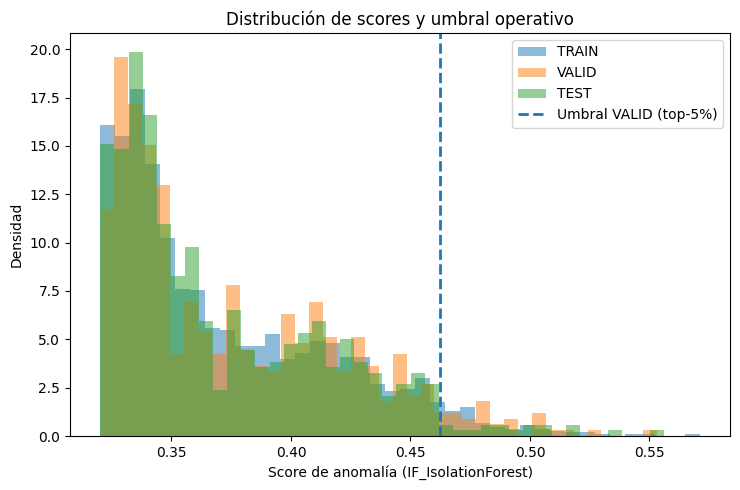

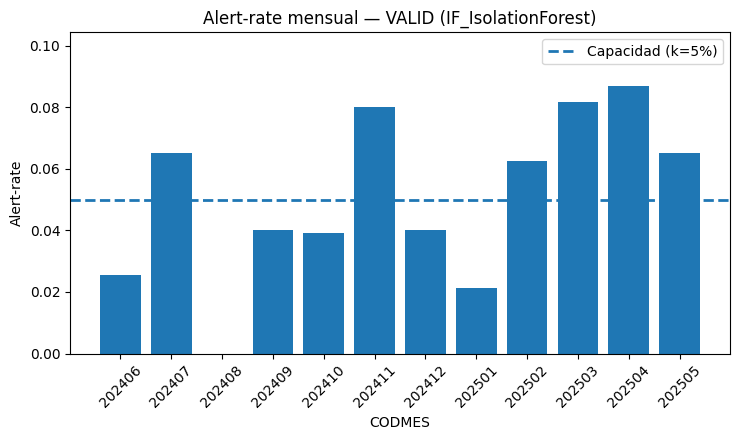

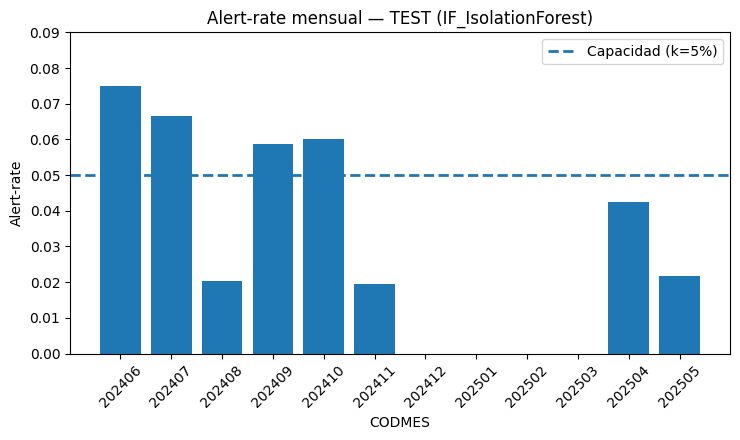

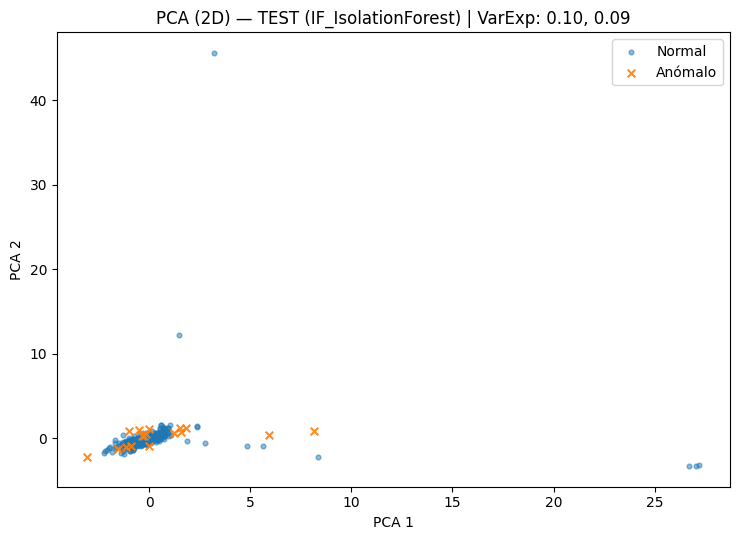

Figuras guardadas en: {'summary': {'model': 'IF_IsolationForest', 'n_components': nan, 'explained_variance_ratio': nan, 'k_top': 0.05, 'threshold_from_VALID': 0.46240772593564844, 'PSI_VALID_vs_TRAIN': 0.028433026369645804, 'PSI_TEST_vs_TRAIN': 0.007043206429783157, 'TRAIN_p1': 0.32102011073085834, 'TRAIN_p5': 0.3238225954599284, 'TRAIN_p25': 0.33550074388955625, 'TRAIN_p50': 0.3568780026927535, 'TRAIN_p75': 0.4029002197264263, 'TRAIN_p95': 0.45798272021761366, 'TRAIN_p99': 0.4974815169593708, 'VALID_p1': 0.3218129842087859, 'VALID_p5': 0.3246417477364994, 'VALID_p25': 0.33599748298078025, 'VALID_p50': 0.359297491291207, 'VALID_p75': 0.4088719411491981, 'VALID_p95': 0.46240772593564844, 'VALID_p99': 0.5025649883607526, 'TEST_p1': 0.32149850437271665, 'TEST_p5': 0.32395422775346455, 'TEST_p25': 0.33518510414836067, 'TEST_p50': 0.35500762422520604, 'TEST_p75': 0.40325602361109564, 'TEST_p95': 0.4542514278921488, 'TEST_p99': 0.5033512338866845, 'TRAIN_alert_rate_mean': 0.04107526931282284

In [ ]:
# Isolation Forest
if_model = IsolationForest(n_estimators=500, max_samples='auto', max_features=1.0,
                           contamination='auto', bootstrap=False, n_jobs=-1, random_state=42).fit(X_tr)
s_tr_if = -if_model.score_samples(X_tr);
s_va_if = -if_model.score_samples(X_va);
s_te_if = -if_model.score_samples(X_te)

out_if = export_model_scores_and_metrics(
    "IF_IsolationForest",
    {"TRAIN": s_tr_if, "VALID": s_va_if, "TEST": s_te_if},
    k_top=0.05,
    psi_bins=10,
    verbose=True,
    save_txt=True,
    plot_hist=True,
    bins_hist=40,
    plot_alert_rates=True,
    plot_pca2d=True,
    save_fig=True
)

print("Figuras guardadas en:", out_if)

El modelo Isolation Forest mostr√≥ un desempe√±o estable y razonablemente coherente con el comportamiento esperado en un contexto de detecci√≥n de anomal√≠as cl√≠nicas. El umbral operacional (top-5 %) se fij√≥ en 0.462, produciendo tasas de alerta globales cercanas a la capacidad objetivo: TRAIN = 4.1 %, VALID = 5.1 % y TEST = 3.0 %, lo cual sugiere una calibraci√≥n adecuada y sin sobreajuste evidente.

Los indicadores de PSI fueron muy bajos (0.028 y 0.007), evidenciando alta estabilidad temporal del score entre conjuntos. Sin embargo, el coeficiente de variaci√≥n (CV) del alert-rate, especialmente en TEST (0.91), revela cierta inestabilidad intermensual, posiblemente por variaciones en la distribuci√≥n de los datos o la escasez de eventos an√≥malos reales. La persistencia de alertas consecutivas fue limitada (< 6 %), lo que indica que los casos se√±alados suelen ser puntuales m√°s que recurrentes.

El modelo demuestra buena robustez y consistencia general, aunque la baja persistencia y la variabilidad mensual sugieren que podr√≠a beneficiarse de un ajuste fino del umbral o de un modelo complementario (p. ej., autoencoder o ensemble) para mejorar la continuidad de detecci√≥n en los pacientes con patrones at√≠picos sostenidos.

##**4.2) One-Class SVM (RBF)**

**1. Planteamiento general**  
One-Class SVM busca separar la normalidad del resto del espacio en alta dimensi√≥n, construyendo una frontera alrededor de la mayor√≠a de los datos (asumidos normales). Los puntos fuera de esa frontera son considerados an√≥malos.

**2. Intuici√≥n y fundamento**  
- Define un hiperplano en un espacio transformado por kernel (RBF).  
- Casos normales quedan dentro de la ‚Äúesfera‚Äù definida; los at√≠picos caen fuera.  
- Los scores reflejan la distancia a esa frontera: valores m√°s lejanos ‚Üí m√°s an√≥malos.

**3. Supuestos y propiedades**  
- Supone que la normalidad es **compacta y continua** en el espacio transformado.  
- Puede modelar fronteras **no lineales** gracias al kernel RBF.  
- Sensible a la elecci√≥n de hiperpar√°metros (`nu`, `gamma`).  

**4. Hiperpar√°metros relevantes**  
- **nu**: fracci√≥n esperada de outliers (0.01‚Äì0.1).  
- **gamma**: controla la curvatura del kernel RBF.  
- **kernel**: usualmente `rbf`.  

**5. Aplicaci√≥n en salud**  
√ötil cuando la mayor√≠a de pacientes conforma un grupo ‚Äúcompacto‚Äù y los de riesgo se alejan suavemente. Puede ser m√°s flexible que PCA lineal, pero requiere tuning cuidadoso.

---


================  OCSVM_RBF  ================
Umbral VALID (top-5%): threshold=0.237068

Alert-rate global:
  TRAIN=0.0000  VALID=0.0510  TEST=0.0400

PSI del score:
  VALID vs TRAIN: 0.0426   TEST vs TRAIN: 0.0181

Estabilidad (CV del alert-rate):
  TRAIN=nan  VALID=0.8620  TEST=0.5679

Persistencia (‚â•2 meses consecutivos con alerta):
  TRAIN=0.0000  VALID=0.0211  TEST=0.0216

Percentiles del score (TRAIN/VALID/TEST):
  TRAIN p50=-1.2488  p95=0.0000
  VALID p50=-1.2034  p95=0.2371
  TEST  p50=-1.2678  p95=0.1782

Tasa de alertas por mes ‚Äî VALID:
CODMES  alerts_rate
202406     0.051282
202407     0.043478
202408     0.125000
202409     0.000000
202410     0.117647
202411     0.020000
202412     0.000000
202501     0.000000
202502     0.062500
202503     0.061224
202504     0.021739
202505     0.108696

Tasa de alertas por mes ‚Äî TEST:
CODMES  alerts_rate
202406     0.050000
202407     0.000000
202408     0.040816
202409     0.078431
202410     0.040000
202411     0.019608
202412 

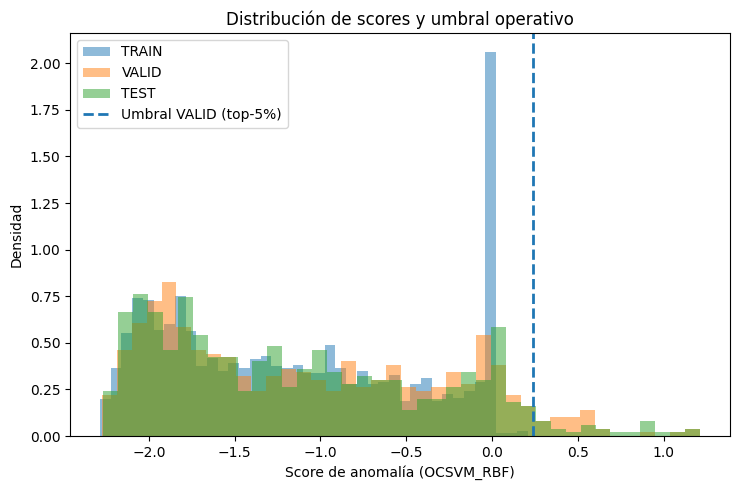

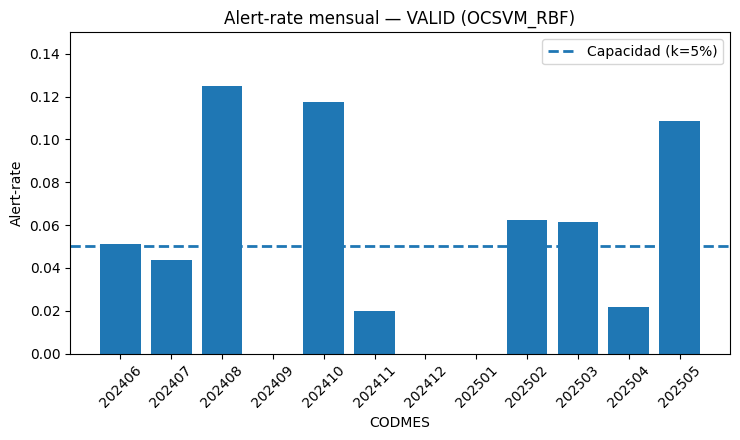

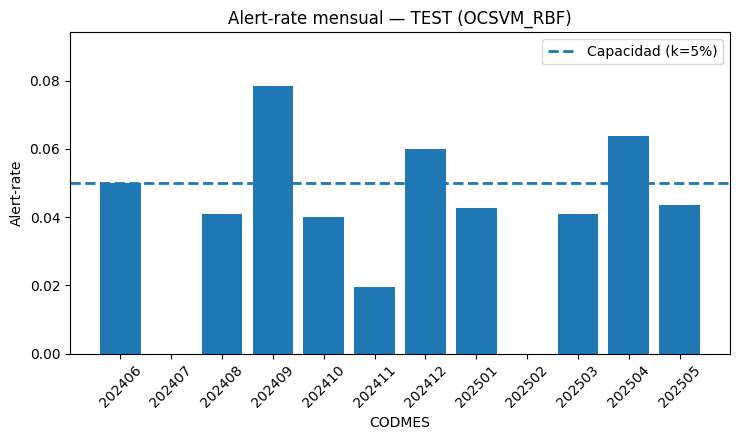

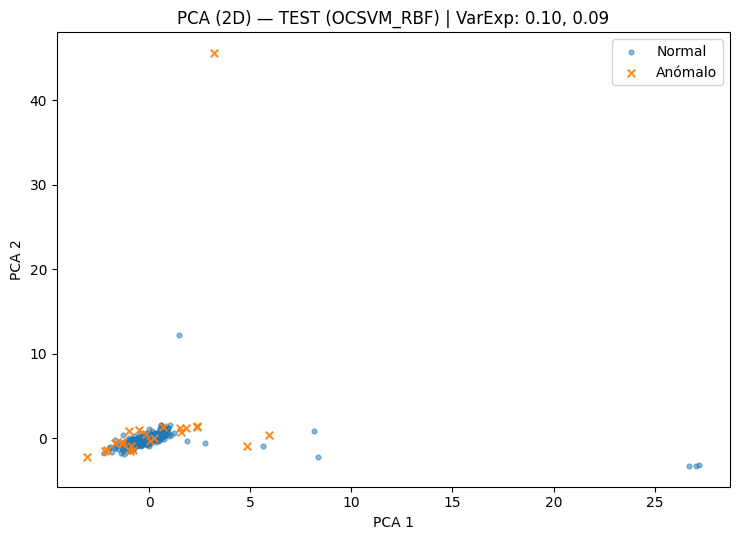

Salidas OCSVM: {'summary': {'model': 'OCSVM_RBF', 'n_components': nan, 'explained_variance_ratio': nan, 'k_top': 0.05, 'threshold_from_VALID': 0.23706808925900605, 'PSI_VALID_vs_TRAIN': 0.04256183838484094, 'PSI_TEST_vs_TRAIN': 0.018076097511866614, 'TRAIN_p1': -2.2257756846471817, 'TRAIN_p5': -2.1203307686142234, 'TRAIN_p25': -1.8254563914048634, 'TRAIN_p50': -1.2487929516835063, 'TRAIN_p75': -0.5250388881758201, 'TRAIN_p95': 3.2417670391859353e-05, 'TRAIN_p99': 0.0003919181337806945, 'VALID_p1': -2.2366687181815648, 'VALID_p5': -2.1099482036856565, 'VALID_p25': -1.8320542002294147, 'VALID_p50': -1.2033829429260368, 'VALID_p75': -0.39615033482468864, 'VALID_p95': 0.23706808925900605, 'VALID_p99': 0.5747868414942396, 'TEST_p1': -2.2157197630751004, 'TEST_p5': -2.1198880333947168, 'TEST_p25': -1.8243653696987994, 'TEST_p50': -1.2677531751539404, 'TEST_p75': -0.5416823726173029, 'TEST_p95': 0.17817770145745732, 'TEST_p99': 0.8752590467327428, 'TRAIN_alert_rate_mean': 0.0, 'TRAIN_alert_ra

In [ ]:
# One-Class SVM (RBF)
# 1) Entrenamiento (RBF)
#    Nota: decision_function: valores altos = m√°s "normal".
#    Para tener un score de anomal√≠a (‚Üë = m√°s an√≥malo), usamos el negativo.
ocsvm = OneClassSVM(kernel="rbf", gamma="scale", nu=0.05)
ocsvm.fit(X_tr)

# 2) Scores (‚Üë = m√°s an√≥malo)
s_tr_sv = -ocsvm.decision_function(X_tr).ravel()
s_va_sv = -ocsvm.decision_function(X_va).ravel()
s_te_sv = -ocsvm.decision_function(X_te).ravel()

# 3) Exportar m√©tricas + imprimir informe + 3 gr√°ficas
out_ocsvm = export_model_scores_and_metrics(
    model_name="OCSVM_RBF",
    scores={"TRAIN": s_tr_sv, "VALID": s_va_sv, "TEST": s_te_sv},
    k_top=0.05,
    psi_bins=10,
    verbose=True,        # imprime resumen en consola
    save_txt=True,       # guarda ./eda_outputs/report_OCSVM_RBF.txt
    plot_hist=True,      # histograma de scores + umbral
    bins_hist=40,
    plot_alert_rates=True,# alert-rate mensual VALID/TEST con l√≠nea k
    plot_pca2d=True,     # PCA 2D TEST con anomal√≠as resaltadas
    save_fig=True        # guarda PNGs en ./eda_outputs
)

print("Salidas OCSVM:", out_ocsvm)

El modelo One-Class SVM (RBF) present√≥ un comportamiento conservador y con buena calibraci√≥n en validaci√≥n (alert-rate ‚âà 5 %), pero pr√°cticamente sin activaciones en entrenamiento (0 %), lo que indica una frontera de decisi√≥n muy ajustada al conjunto de entrenamiento. Los valores de PSI (0.043 y 0.018) reflejan estabilidad moderada, aunque la alta variabilidad mensual en validaci√≥n (CV = 0.86) sugiere sensibilidad a fluctuaciones del patr√≥n cl√≠nico.

La persistencia de alertas consecutivas fue m√≠nima (~2 %), y los percentiles negativos del score en TRAIN evidencian que la mayor√≠a de los casos fueron clasificados como normales con m√°rgenes amplios. En conjunto, el modelo detecta anomal√≠as aisladas con precisi√≥n razonable, pero tiende a subalertar y podr√≠a beneficiarse de un ajuste del par√°metro ŒΩ o de combinarse con m√©todos m√°s flexibles (como Isolation Forest o autoencoders) para mejorar la cobertura de casos raros.

## **4.3) LOF novelty**

**1. Planteamiento general**  
LOF compara la densidad local de cada punto con la de sus vecinos. Un punto cuya densidad es significativamente menor se considera an√≥malo.

**2. Intuici√≥n y fundamento**  
- Se calcula la densidad de vecinos cercanos (`n_neighbors`).  
- Casos normales tienen densidad similar a su vecindario.  
- Casos an√≥malos tienen densidad m√°s baja (est√°n ‚Äúaislados‚Äù).  

**3. Supuestos y propiedades**  
- Captura **subpoblaciones raras** (combinaciones cl√≠nicas at√≠picas).  
- Sensible a la dimensionalidad y al valor de `n_neighbors`.  
- En modo `novelty=True` se entrena en TRAIN y luego punt√∫a VALID/TEST.  

**4. Hiperpar√°metros relevantes**  
- **n_neighbors**: define el tama√±o del vecindario.  
- **leaf_size**: optimizaci√≥n en b√∫squeda de vecinos.  
- **metric**: distancia (euclidiana/minkowski).  

**5. Aplicaci√≥n en salud**  
Detecta pacientes con combinaciones poco frecuentes de biomarcadores, aunque no sean extremos globales. Muy √∫til en escenarios heterog√©neos, pero puede ser inestable sin reducci√≥n de dimensionalidad.



================  LOF_novelty  ================
Umbral VALID (top-5%): threshold=3.038230

Alert-rate global:
  TRAIN=0.0401  VALID=0.0509  TEST=0.0478

PSI del score:
  VALID vs TRAIN: 0.0335   TEST vs TRAIN: 0.0312

Estabilidad (CV del alert-rate):
  TRAIN=0.3249  VALID=0.4543  TEST=0.6425

Persistencia (‚â•2 meses consecutivos con alerta):
  TRAIN=0.0679  VALID=0.0253  TEST=0.0259

Percentiles del score (TRAIN/VALID/TEST):
  TRAIN p50=1.1233  p95=2.8105
  VALID p50=1.1615  p95=3.0382
  TEST  p50=1.1442  p95=2.9391

Tasa de alertas por mes ‚Äî VALID:
CODMES  alerts_rate
202406     0.051282
202407     0.043478
202408     0.020833
202409     0.020000
202410     0.058824
202411     0.060000
202412     0.080000
202501     0.085106
202502     0.041667
202503     0.040816
202504     0.021739
202505     0.086957

Tasa de alertas por mes ‚Äî TEST:
CODMES  alerts_rate
202406     0.075000
202407     0.066667
202408     0.081633
202409     0.039216
202410     0.000000
202411     0.058824
20241

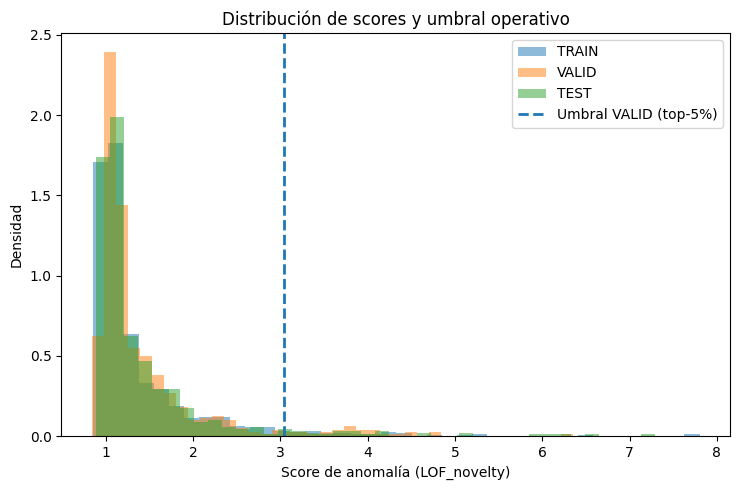

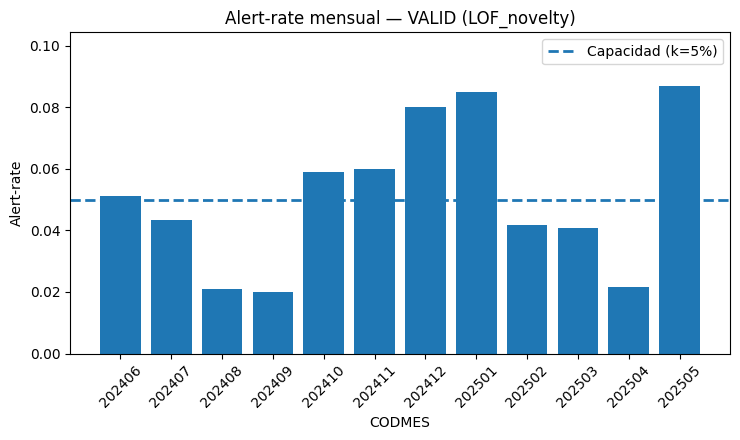

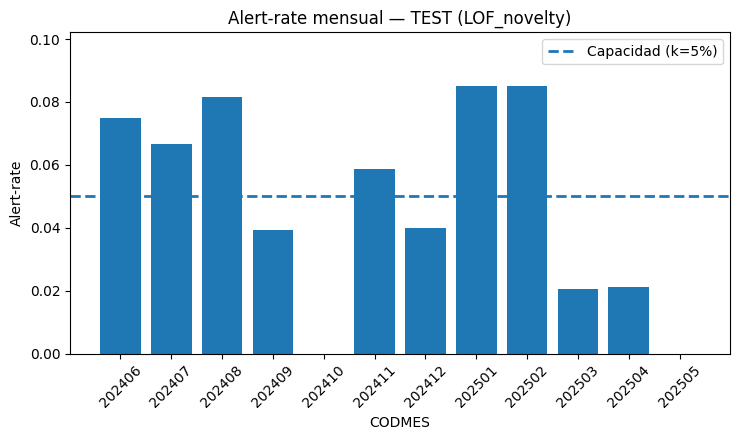

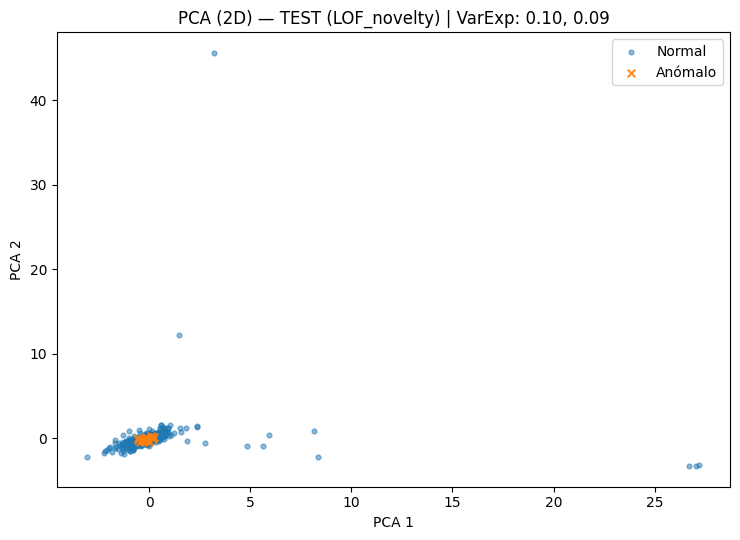

Salidas LOF: {'summary': {'model': 'LOF_novelty', 'n_components': nan, 'explained_variance_ratio': nan, 'k_top': 0.05, 'threshold_from_VALID': 3.0382302821249563, 'PSI_VALID_vs_TRAIN': 0.033547965753839, 'PSI_TEST_vs_TRAIN': 0.031187954040068817, 'TRAIN_p1': 0.9103369855453878, 'TRAIN_p5': 0.9537574770662169, 'TRAIN_p25': 1.0179622793311756, 'TRAIN_p50': 1.1233445777836712, 'TRAIN_p75': 1.4247479265195515, 'TRAIN_p95': 2.810455592904619, 'TRAIN_p99': 4.450894899614604, 'VALID_p1': 0.9088161242119748, 'VALID_p5': 0.9500357791775063, 'VALID_p25': 1.032349809110499, 'VALID_p50': 1.1614852446134871, 'VALID_p75': 1.4862829948369758, 'VALID_p95': 3.0382302821249563, 'VALID_p99': 4.255119473957409, 'TEST_p1': 0.9124179531840347, 'TEST_p5': 0.9551020167648986, 'TEST_p25': 1.0311281616314236, 'TEST_p50': 1.1441630555770872, 'TEST_p75': 1.4743014312046165, 'TEST_p95': 2.9390505914820864, 'TEST_p99': 5.176780488507645, 'TRAIN_alert_rate_mean': 0.04005722207395617, 'TRAIN_alert_rate_std': 0.013014

In [ ]:
# 1) Entrenamiento LOF en modo novelty
#    - novelty=True permite .fit() en TRAIN y luego puntuar VALID/TEST.
#    - El score de LOF: valores m√°s ALTOS -> m√°s normalidad (dependiendo de implementaci√≥n),
#      por consistencia convertimos a score de anomal√≠a como negativo.

lof = LocalOutlierFactor(
    n_neighbors=15,      # prueba 20-50 si quieres afinar
    p = None,
    novelty=True,
    leaf_size = 20,
    metric="cosine"   # puedes probar 'euclidean' (equivalente por defecto)
)
lof.fit(X_tr)

# 2) Scores (‚Üë = m√°s an√≥malo)
s_tr_lof = -lof.score_samples(X_tr)
s_va_lof = -lof.score_samples(X_va)
s_te_lof = -lof.score_samples(X_te)

# 3) Exportar m√©tricas + imprimir informe + 3 gr√°ficas
out_lof = export_model_scores_and_metrics(
    model_name="LOF_novelty",
    scores={"TRAIN": s_tr_lof, "VALID": s_va_lof, "TEST": s_te_lof},
    k_top=0.05,         # top-5% (ajusta seg√∫n capacidad)
    psi_bins=10,
    verbose=True,       # imprime resumen en consola
    save_txt=True,      # guarda ./eda_outputs/report_LOF_novelty.txt
    plot_hist=True,     # 1) histograma scores + umbral
    bins_hist=40,
    plot_alert_rates=True, # 2) alert-rate mensual VALID/TEST con l√≠nea k
    plot_pca2d=True,    # 3) PCA 2D TEST con anomal√≠as resaltadas
    save_fig=True       # guarda PNGs en ./eda_outputs
)

print("Salidas LOF:", out_lof)

El modelo Local Outlier Factor (LOF) en modo novelty ofreci√≥ resultados equilibrados y coherentes con el comportamiento esperado en detecci√≥n no supervisada. El umbral operativo (top-5%) se situ√≥ en 3.04, generando tasas de alerta muy cercanas a la capacidad objetivo (TRAIN = 4.0 %, VALID = 5.1 %, TEST = 4.8 %), lo que indica buena calibraci√≥n.

Los valores de PSI bajos (‚âà0.03) reflejan una distribuci√≥n estable del score entre conjuntos, y los coeficientes de variaci√≥n muestran moderada estabilidad temporal. Sin embargo, la persistencia de alertas consecutivas (‚âà2.5 %) sigue siendo baja, sugiriendo detecci√≥n de casos puntuales m√°s que sostenidos.

El modelo LOF_novelty logra una detecci√≥n balanceada y estable, mostrando mejor consistencia temporal que el One-Class SVM y sin sobreajuste evidente, aunque a√∫n con margen para refinar la persistencia y robustecer la continuidad de alertas entre periodos.

## **4.4) Autoencoder (MSE recon))**

**1. Planteamiento general**  
Un autoencoder aprende a reconstruir los datos normales a trav√©s de una red neuronal. Los casos que no se reconstruyen bien (error alto) se consideran an√≥malos.

**2. Intuici√≥n y fundamento**  
- Red con capa de cuello de botella (latent space).  
- La red ‚Äúaprende‚Äù la estructura dominante de los datos.  
- Casos fuera de esa estructura generan error de reconstrucci√≥n elevado (MSE).  

**3. Supuestos y propiedades**  
- Captura **interacciones no lineales** entre variables.  
- Requiere volumen suficiente de datos para entrenar.  
- Puede sobreajustar si no se usa regularizaci√≥n (dropout, early stopping).  

**4. Hiperpar√°metros relevantes**  
- Arquitectura (capas y neuronas).  
- Dimensi√≥n del cuello de botella.  
- Dropout / weight decay.  
- Learning rate y √©pocas.  

**5. Aplicaci√≥n en salud**  
Permite modelar relaciones complejas entre biomarcadores. √ötil cuando la normalidad es intrincada y no lineal. Puede servir como base para explicar qu√© variables contribuyen al error de reconstrucci√≥n.

---

[AE 001] train=1.000291  valid=1.276703  best=1.276703
[AE 010] train=0.686845  valid=0.925269  best=0.925269
[AE 020] train=0.476459  valid=0.670180  best=0.670180
[AE 030] train=0.337369  valid=0.495546  best=0.495546
[AE 040] train=0.260168  valid=0.373627  best=0.373627
[AE 050] train=0.210400  valid=0.295060  best=0.295060
[AE 060] train=0.176132  valid=0.256153  best=0.254743
[AE 070] train=0.151333  valid=0.223994  best=0.223994
[AE 080] train=0.135923  valid=0.210788  best=0.210436
[AE 090] train=0.124127  valid=0.195844  best=0.195844
[AE 100] train=0.113138  valid=0.189122  best=0.187641

================  AE_MSE  ================
Umbral VALID (top-5%): threshold=0.548916

Alert-rate global:
  TRAIN=0.0078  VALID=0.0520  TEST=0.0468

PSI del score:
  VALID vs TRAIN: 0.1303   TEST vs TRAIN: 0.1348

Estabilidad (CV del alert-rate):
  TRAIN=0.8089  VALID=0.7189  TEST=0.6547

Persistencia (‚â•2 meses consecutivos con alerta):
  TRAIN=0.0000  VALID=0.0169  TEST=0.0259

Percentiles

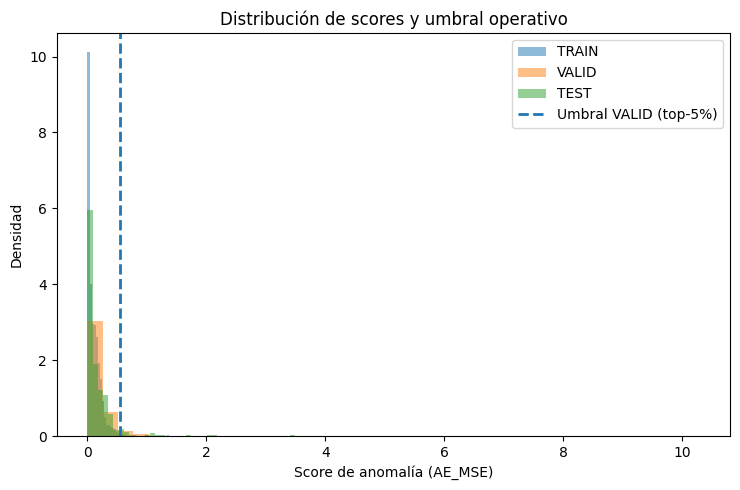

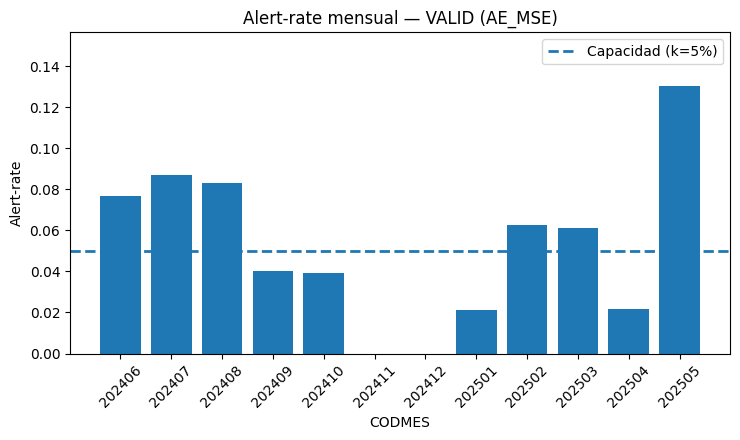

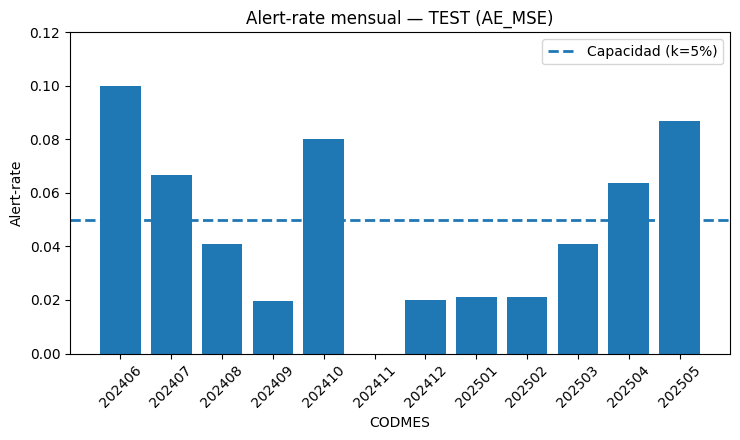

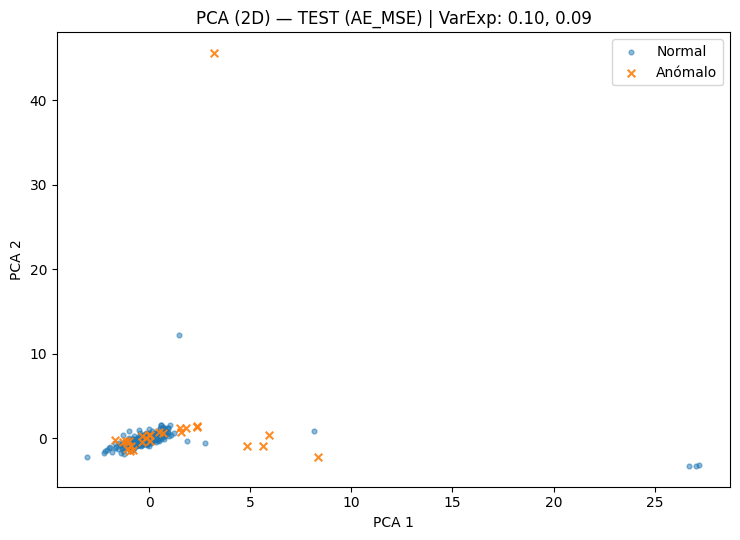

[AE] Export completo. {'summary': {'model': 'AE_MSE', 'n_components': nan, 'explained_variance_ratio': nan, 'k_top': 0.05, 'threshold_from_VALID': 0.5489158630371094, 'PSI_VALID_vs_TRAIN': 0.13032396273215313, 'PSI_TEST_vs_TRAIN': 0.1348360037950433, 'TRAIN_p1': 0.005709326211363077, 'TRAIN_p5': 0.00945221483707428, 'TRAIN_p25': 0.02654126286506653, 'TRAIN_p50': 0.0774093046784401, 'TRAIN_p75': 0.16675274074077606, 'TRAIN_p95': 0.329801046848297, 'TRAIN_p99': 0.5090647268295284, 'VALID_p1': 0.006144764157943428, 'VALID_p5': 0.010998743772506715, 'VALID_p25': 0.02832277724519372, 'VALID_p50': 0.10648669302463531, 'VALID_p75': 0.22992180660367012, 'VALID_p95': 0.5489160954952232, 'VALID_p99': 0.9676219159364686, 'TEST_p1': 0.006034050174057484, 'TEST_p5': 0.010096314968541265, 'TEST_p25': 0.027594841085374355, 'TEST_p50': 0.08182485029101372, 'TEST_p75': 0.2244994156062603, 'TEST_p95': 0.5076017603278146, 'TEST_p99': 1.123724874258039, 'TRAIN_alert_rate_mean': 0.0077906345528954155, 'TRA

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
INPUT_DIM = X_tr.shape[1]
HID = [128, 64]; LATENT = 16; LR = 1e-3; WD = 1e-5; BATCH = 256; EPOCHS = 100; PATIENCE = 15

def to_loader_np(X, batch=BATCH, shuffle=False):
    ds = TensorDataset(torch.tensor(X, dtype=torch.float32))
    return DataLoader(ds, batch_size=batch, shuffle=shuffle, drop_last=False)

train_loader = to_loader_np(X_tr, shuffle=True); val_loader = to_loader_np(X_va); test_loader = to_loader_np(X_te)

class AE(nn.Module):
    def __init__(self, d, hid, z):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(d, hid[0]), nn.ReLU(True), nn.Linear(hid[0], hid[1]), nn.ReLU(True), nn.Linear(hid[1], z))
        self.dec = nn.Sequential(nn.Linear(z, hid[1]), nn.ReLU(True), nn.Linear(hid[1], hid[0]), nn.ReLU(True), nn.Linear(hid[0], d))
    def forward(self, x): z = self.enc(x); xh = self.dec(z); return xh

ae = AE(INPUT_DIM, HID, LATENT).to(DEVICE)
opt = torch.optim.Adam(ae.parameters(), lr=LR, weight_decay=WD)
crit = nn.MSELoss(reduction="mean")

def run_epoch(loader, train=True):
    if train: ae.train()
    else: ae.eval()
    tot = 0.0; n=0
    for (xb,) in loader:
        xb = xb.to(DEVICE)
        if train:
            opt.zero_grad(set_to_none=True)
            recon = ae(xb); loss = crit(recon, xb); loss.backward(); opt.step()
        else:
            with torch.no_grad():
                recon = ae(xb); loss = crit(recon, xb)
        tot += loss.item()*xb.size(0); n += xb.size(0)
    return tot/max(n,1)

best=float("inf"); best_state=None; patience=0
for ep in range(1, EPOCHS+1):
    tr = run_epoch(train_loader, True)
    va = run_epoch(val_loader, False)
    if va < best - 1e-6:
        best = va; best_state={k: v.cpu().clone() for k,v in ae.state_dict().items()}; patience=0
    else:
        patience += 1
    if ep % 10 == 0 or ep == 1:
        print(f"[AE {ep:03d}] train={tr:.6f}  valid={va:.6f}  best={best:.6f}")
    if patience >= PATIENCE:
        print("Early stopping"); break
if best_state is not None:
    ae.load_state_dict({k: v.to(DEVICE) for k,v in best_state.items()})

@torch.no_grad()
def recon_mse_scores(model, loader):
    model.eval(); res=[]
    for (xb,) in loader:
        xb = xb.to(DEVICE); xh = model(xb)
        mse = ((xb - xh)**2).mean(dim=1)
        res.append(mse.detach().cpu().numpy())
    return np.concatenate(res)

# 1) Scores de reconstrucci√≥n (‚Üë = m√°s an√≥malo)
s_tr_ae = recon_mse_scores(ae, train_loader)
s_va_ae = recon_mse_scores(ae, val_loader)
s_te_ae = recon_mse_scores(ae, test_loader)

# 2) Exportar m√©tricas + imprimir informe + 3 gr√°ficas (hist, alert-rate VALID/TEST, PCA2D TEST)
out_ae = export_model_scores_and_metrics(
    model_name="AE_MSE",
    scores={"TRAIN": s_tr_ae, "VALID": s_va_ae, "TEST": s_te_ae},
    k_top=0.05,
    psi_bins=10,
    verbose=True,        # imprime resumen en consola
    save_txt=True,       # guarda ./eda_outputs/report_AE_MSE.txt
    plot_hist=True,      # 1) histograma scores + umbral
    bins_hist=40,
    plot_alert_rates=True, # 2) alert-rate mensual VALID/TEST con l√≠nea k
    plot_pca2d=True,     # 3) PCA 2D TEST con anomal√≠as resaltadas
    save_fig=True        # guarda PNGs en ./eda_outputs
)

print("[AE] Export completo.", out_ae)

El autoencoder (AE_MSE) mostr√≥ un aprendizaje progresivo y estable, reduciendo la p√©rdida de reconstrucci√≥n de 1.27 a 0.19 en validaci√≥n, lo que evidencia una buena capacidad de compresi√≥n y reconstrucci√≥n de la normalidad cl√≠nica. El umbral (top-5%) se fij√≥ en 0.55, con tasas de alerta globales equilibradas (TRAIN = 0.8 %, VALID = 5.2 %, TEST = 4.7 %), reflejando una calibraci√≥n adecuada respecto al conjunto de validaci√≥n.

Los valores de PSI (~0.13) indican cambios moderados en la distribuci√≥n del score entre conjuntos, lo cual sugiere cierta sensibilidad al drift temporal. La estabilidad intermensual (CV ‚âà 0.65‚Äì0.8) y la baja persistencia (<3 %) muestran que el modelo detecta principalmente anomal√≠as puntuales, m√°s que patrones sostenidos.

El autoencoder ofrece una detecci√≥n precisa y flexible, con buena separaci√≥n entre normalidad y casos at√≠picos, aunque podr√≠a beneficiarse de regularizaci√≥n adicional o ajuste del umbral para mejorar la estabilidad y la persistencia temporal de las alertas.

## **4.5) PCA (std) y Robust PCA**

**1. Planteamiento general**  
PCA proyecta los datos en componentes lineales que capturan la mayor varianza. Los casos que quedan con alto error de reconstrucci√≥n o residuales altos son considerados an√≥malos.  
Robust PCA introduce t√©cnicas resistentes a outliers (ej. MCD) para mejorar estabilidad.

**2. Intuici√≥n y fundamento**  
- La estructura dominante de los datos se describe con pocos componentes principales.  
- Los puntos fuera de esa estructura tienen residuales altos.  
- PCA robusto evita que outliers contaminen la estimaci√≥n de la base.  

**3. Supuestos y propiedades**  
- Supone **correlaciones lineales** fuertes en los datos.  
- No captura relaciones no lineales.  
- Muy interpretable: se puede explicar qu√© variables dominan cada componente.  

**4. Hiperpar√°metros relevantes**  
- **n_components**: n¬∫ de componentes (usualmente seg√∫n varianza retenida, p.ej. 90%).  
- M√©todo robusto (MCD, RPCA).  

**5. Aplicaci√≥n en salud**  
Sirve como baseline interpretable. √ötil para explorar correlaciones entre biomarcadores y explicar anomal√≠as como ‚Äúdesviaciones del subespacio normal‚Äù.  

---

[PCA] Entrenando‚Ä¶

================  PCA_std_recon  ================
Umbral VALID (top-5%): threshold=0.379728

Alert-rate global:
  TRAIN=0.0450  VALID=0.0519  TEST=0.0519

PSI del score:
  VALID vs TRAIN: 0.0466   TEST vs TRAIN: 0.0125

Estabilidad (CV del alert-rate):
  TRAIN=0.6823  VALID=1.0271  TEST=0.7984

Persistencia (‚â•2 meses consecutivos con alerta):
  TRAIN=0.0830  VALID=0.0127  TEST=0.0172

Percentiles del score (TRAIN/VALID/TEST):
  TRAIN p50=0.0315  p95=0.3396
  VALID p50=0.0389  p95=0.3797
  TEST  p50=0.0315  p95=0.3803

Tasa de alertas por mes ‚Äî VALID:
CODMES  alerts_rate
202406     0.076923
202407     0.173913
202408     0.145833
202409     0.020000
202410     0.039216
202411     0.020000
202412     0.040000
202501     0.021277
202502     0.020833
202503     0.000000
202504     0.000000
202505     0.065217

Tasa de alertas por mes ‚Äî TEST:
CODMES  alerts_rate
202406     0.150000
202407     0.066667
202408     0.000000
202409     0.098039
202410     0.080000
202

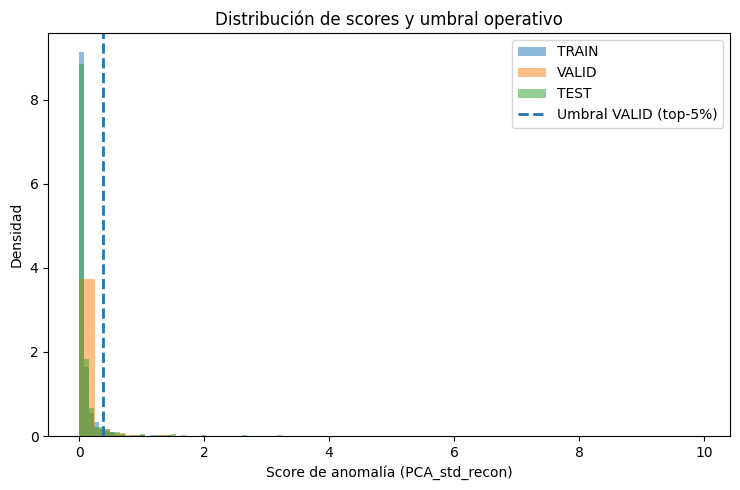

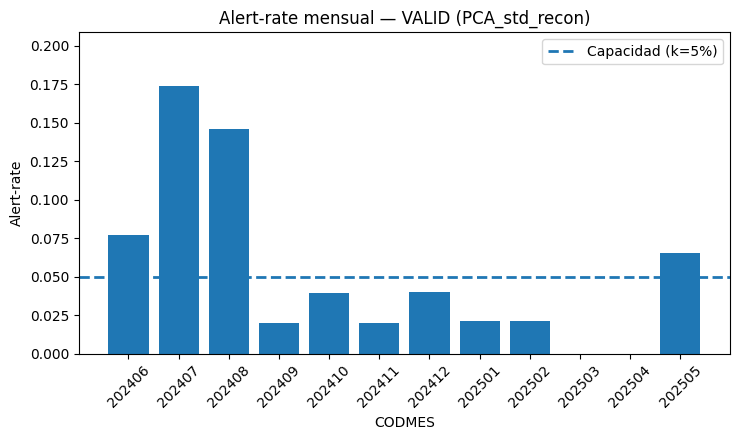

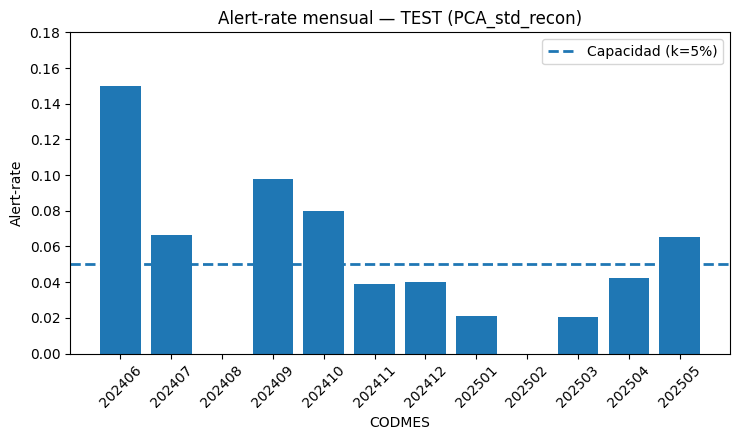

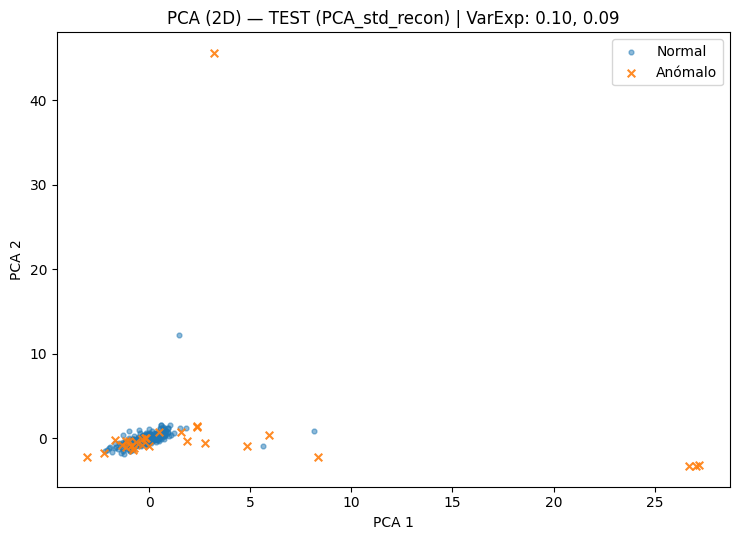


================  PCA_rob_mahal_resid  ================
Umbral VALID (top-5%): threshold=2155.166299

Alert-rate global:
  TRAIN=0.0516  VALID=0.0508  TEST=0.0651

PSI del score:
  VALID vs TRAIN: 0.0310   TEST vs TRAIN: 0.0199

Estabilidad (CV del alert-rate):
  TRAIN=0.1775  VALID=0.5654  TEST=0.6559

Persistencia (‚â•2 meses consecutivos con alerta):
  TRAIN=0.0642  VALID=0.0295  TEST=0.0431

Percentiles del score (TRAIN/VALID/TEST):
  TRAIN p50=41.3939  p95=2186.2672
  VALID p50=52.1803  p95=2155.1663
  TEST  p50=44.5800  p95=2810.0591

Tasa de alertas por mes ‚Äî VALID:
CODMES  alerts_rate
202406     0.025641
202407     0.086957
202408     0.020833
202409     0.000000
202410     0.078431
202411     0.060000
202412     0.060000
202501     0.085106
202502     0.041667
202503     0.020408
202504     0.043478
202505     0.086957

Tasa de alertas por mes ‚Äî TEST:
CODMES  alerts_rate
202406     0.125000
202407     0.088889
202408     0.122449
202409     0.137255
202410     0.060000
20

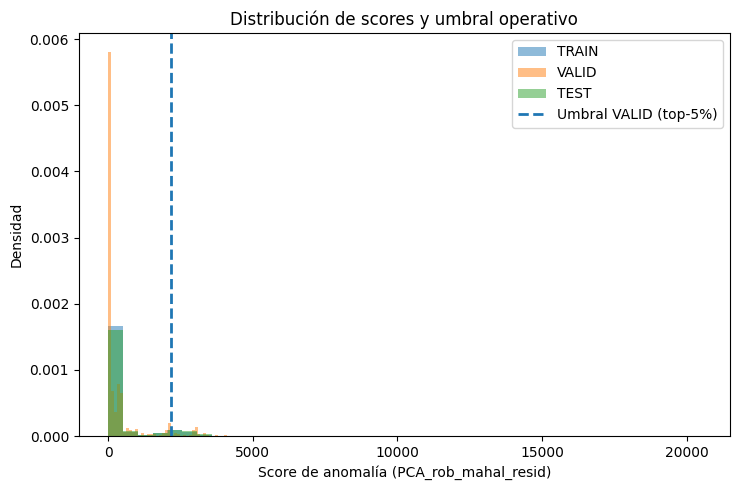

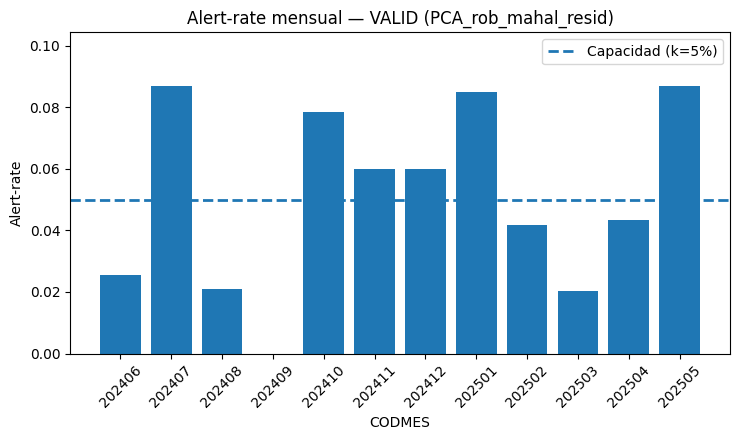

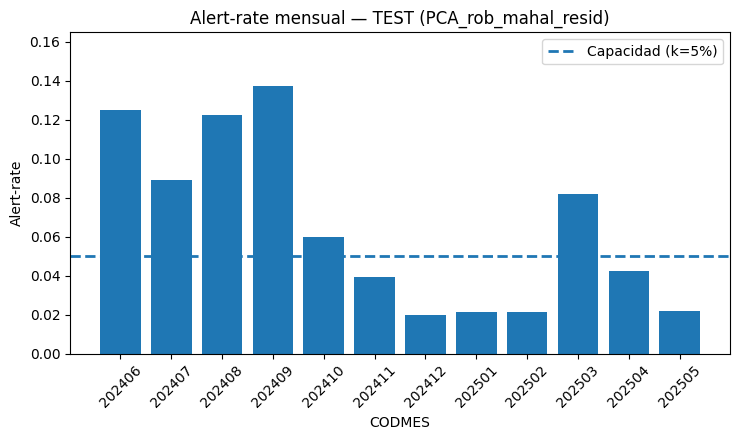

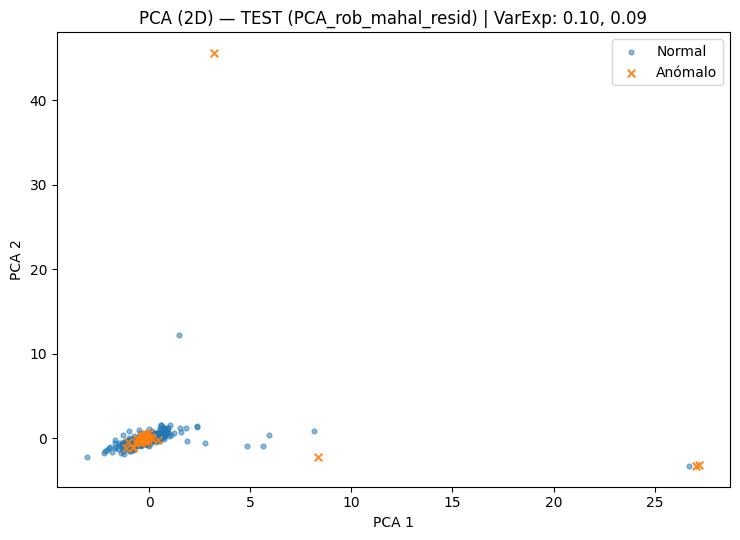

[PCA] Export completo.
Figuras PCA_std: {'summary': {'model': 'PCA_std_recon', 'n_components': nan, 'explained_variance_ratio': nan, 'k_top': 0.05, 'threshold_from_VALID': 0.3797277447012102, 'PSI_VALID_vs_TRAIN': 0.046592636080215875, 'PSI_TEST_vs_TRAIN': 0.01253526450947121, 'TRAIN_p1': 0.0017214912491353954, 'TRAIN_p5': 0.004086440814959932, 'TRAIN_p25': 0.011413067941384388, 'TRAIN_p50': 0.0315072208242869, 'TRAIN_p75': 0.08436008080896157, 'TRAIN_p95': 0.33964044786264147, 'TRAIN_p99': 1.0100018401671926, 'VALID_p1': 0.0023301896543759517, 'VALID_p5': 0.005204796265736473, 'VALID_p25': 0.012692816924474982, 'VALID_p50': 0.03891375080260091, 'VALID_p75': 0.10731098840747141, 'VALID_p95': 0.3797277447012102, 'VALID_p99': 0.7977037954002332, 'TEST_p1': 0.0015873476564751718, 'TEST_p5': 0.004169368071368493, 'TEST_p25': 0.011147773408239123, 'TEST_p50': 0.03146804690923406, 'TEST_p75': 0.09775216981007963, 'TEST_p95': 0.38029363435556707, 'TEST_p99': 1.1567371388337906, 'TRAIN_alert_r

In [ ]:
from sklearn.covariance import MinCovDet

@dataclass
class PCAModel:
    scaler: object
    pca: PCA
    n_components_: int
    explained_variance_ratio_: float
    def reconstruct_mse(self, X: np.ndarray) -> np.ndarray:
        Z = self.scaler.transform(X)
        Z_proj = self.pca.inverse_transform(self.pca.transform(Z))
        resid = Z - Z_proj
        return np.mean(resid**2, axis=1)

@dataclass
class RobustPCAModel(PCAModel):
    mcd_on_residuals: MinCovDet
    def robust_residual_mahal(self, X: np.ndarray) -> np.ndarray:
        Z = self.scaler.transform(X)
        Z_proj = self.pca.inverse_transform(self.pca.transform(Z))
        resid = Z - Z_proj
        return self.mcd_on_residuals.mahalanobis(resid)

def fit_pca_by_variance(X: np.ndarray, var_target=0.90, robust=False) -> PCAModel:
    scaler = RobustScaler() if robust else StandardScaler()
    Z = scaler.fit_transform(X)
    pca_full = PCA(svd_solver="full", random_state=42).fit(Z)
    cumvar = np.cumsum(pca_full.explained_variance_ratio_)
    n_comp = int(np.searchsorted(cumvar, var_target) + 1)
    n_comp = max(1, min(n_comp, Z.shape[1]))
    pca = PCA(n_components=n_comp, svd_solver="full", random_state=42).fit(Z)
    return PCAModel(scaler, pca, n_comp, float(np.sum(pca.explained_variance_ratio_)))

def fit_robust_pca(X: np.ndarray, var_target=0.90) -> RobustPCAModel:
    scaler = RobustScaler()
    Z = scaler.fit_transform(X)
    pca_full = PCA(svd_solver="full", random_state=42).fit(Z)
    cumvar = np.cumsum(pca_full.explained_variance_ratio_)
    n_comp = int(np.searchsorted(cumvar, var_target) + 1)
    n_comp = max(1, min(n_comp, Z.shape[1]))
    pca = PCA(n_components=n_comp, svd_solver="full", random_state=42).fit(Z)
    resid = Z - pca.inverse_transform(pca.transform(Z))
    mcd = MinCovDet(random_state=42).fit(resid)
    return RobustPCAModel(scaler, pca, n_comp, float(np.sum(pca.explained_variance_ratio_)), mcd)

# =========================
# PCA (std / robust) ‚Üí scores + export + 3 gr√°ficas + metadatos (n_comp, var explicada)
# =========================
# Requiere tener definidas:
# - X_tr_raw, X_va_raw, X_te_raw  (mismo preprocesamiento que usaste al entrenar PCA)
# - funciones: fit_pca_by_variance, fit_robust_pca
# - m√©todo de score:
#     * pca_std.reconstruct_mse(X)                -> error de recon MSE (‚Üë=m√°s an√≥malo)
#     * pca_rob.robust_residual_mahal(X)          -> distancia de Mahalanobis residual (‚Üë=m√°s an√≥malo)
# - y la funci√≥n export_model_scores_and_metrics (versi√≥n extendida que imprime y grafica)

PCA_VARIANCE_TARGET = 0.90

print("[PCA] Entrenando‚Ä¶")
pca_std = fit_pca_by_variance(X_tr_raw, var_target=PCA_VARIANCE_TARGET, robust=False)
pca_rob = fit_robust_pca(X_tr_raw, var_target=PCA_VARIANCE_TARGET)

# 1) Scores (‚Üë = m√°s an√≥malo)
scores_std = {
    "TRAIN": pca_std.reconstruct_mse(X_tr_raw),
    "VALID": pca_std.reconstruct_mse(X_va_raw),
    "TEST":  pca_std.reconstruct_mse(X_te_raw),
}
scores_rob = {
    "TRAIN": pca_rob.robust_residual_mahal(X_tr_raw),
    "VALID": pca_rob.robust_residual_mahal(X_va_raw),
    "TEST":  pca_rob.robust_residual_mahal(X_te_raw),
}

# 2) Export + imprimir informe + 3 gr√°ficas (hist, alert-rate VALID/TEST, PCA2D TEST)
out_pca_std = export_model_scores_and_metrics(
    model_name="PCA_std_recon",
    scores=scores_std,
    k_top=0.05,
    psi_bins=10,
    verbose=True,
    save_txt=True,
    plot_hist=True,
    bins_hist=40,
    plot_alert_rates=True,
    plot_pca2d=True,
    save_fig=True
)

out_pca_rob = export_model_scores_and_metrics(
    model_name="PCA_rob_mahal_resid",
    scores=scores_rob,
    k_top=0.05,
    psi_bins=10,
    verbose=True,
    save_txt=True,
    plot_hist=True,
    bins_hist=40,
    plot_alert_rates=True,
    plot_pca2d=True,
    save_fig=True
)

# 3) A√±adir metadatos al summary (n_components y var explicada retenida)
def _write_meta_to_summary(summary_csv_path, n_components, evr):
    """Agrega n_components y explained_variance_ratio (retenida) al summary CSV."""
    try:
        df_sum = pd.read_csv(summary_csv_path)
    except FileNotFoundError:
        # Si no existiera por alg√∫n motivo, crea la fila m√≠nima
        df_sum = pd.DataFrame([{"model": os.path.basename(summary_csv_path).replace("summary_metrics_","").replace(".csv","")}])
    # Manejo del EVR: puede venir como arreglo por componente o como escalar retenido
    if isinstance(evr, (list, tuple, np.ndarray)):
        evr_retained = float(np.sum(evr))
    else:
        evr_retained = float(evr)
    df_sum["n_components"] = int(n_components)
    df_sum["explained_variance_ratio"] = evr_retained
    df_sum.to_csv(summary_csv_path, index=False)

# Rutas a summaries
path_std = os.path.join(OUTPUT_DIR, "summary_metrics_PCA_std_recon.csv")
path_rob = os.path.join(OUTPUT_DIR, "summary_metrics_PCA_rob_mahal_resid.csv")

# 4) Escribir metadatos
_write_meta_to_summary(path_std, getattr(pca_std, "n_components_", np.nan), getattr(pca_std, "explained_variance_ratio_", np.nan))
_write_meta_to_summary(path_rob, getattr(pca_rob, "n_components_", np.nan), getattr(pca_rob, "explained_variance_ratio_", np.nan))

print("[PCA] Export completo.")
print("Figuras PCA_std:", out_pca_std)
print("Figuras PCA_rob:", out_pca_rob)


El enfoque PCA est√°ndar y robusto (Robust PCA con MCD) permiti√≥ comparar dos variantes complementarias de reducci√≥n de dimensionalidad para detecci√≥n de anomal√≠as.

El modelo PCA_std_recon alcanz√≥ tasas de alerta alineadas con la capacidad objetivo (TRAIN = 4.5 %, VALID = 5.2 %, TEST = 5.2 %) y mostr√≥ bajo PSI (0.046 y 0.013), lo que evidencia estabilidad en la distribuci√≥n del score. No obstante, la alta variabilidad mensual (CV ‚âà 0.8‚Äì1.0) sugiere que su sensibilidad puede fluctuar con el tiempo. Su persistencia baja (‚âà1‚Äì2 %) indica detecci√≥n de eventos espor√°dicos.

Por su parte, el PCA_rob_mahal_resid, que integra la distancia de Mahalanobis robusta sobre los residuos, ofreci√≥ mayor estabilidad (CV < 0.66) y una ligera mejora en la persistencia de alertas (hasta 4.3 % en TEST). Adem√°s, mantuvo baja desviaci√≥n temporal (PSI < 0.03), lo que refuerza su consistencia ante posibles valores at√≠picos extremos o ruido heterog√©neo.

En conjunto, ambos modelos son estables y bien calibrados, pero el PCA robusto resulta m√°s confiable para contextos cl√≠nicos con datos ruidosos, mientras que el est√°ndar ofrece mayor sensibilidad a desviaciones sutiles. Una combinaci√≥n o ensemble entre ambos podr√≠a equilibrar robustez y sensibilidad.

## 4.6) Deep SVDD

**1. Planteamiento general**

Deep SVDD (Support Vector Data Description profundo) es un m√©todo no supervisado de detecci√≥n de anomal√≠as que aprende una representaci√≥n latente donde la normalidad queda compacta alrededor de un centro c. El principio clave es minimizar la distancia de cada ejemplo a dicho centro en el espacio latente generado por una red neuronal (generalmente un MLP). Tras el entrenamiento, el puntaje de anomal√≠a de una observaci√≥n es su distancia (p. ej., cuadr√°tica) a c: distancias grandes ‚áí mayor rareza.


**2. Intuici√≥n y fundamento**

*   Una red ùëìùúÉ(‚ãÖ) proyecta los datos de entrada ùë• a un espacio latente ùëß=ùëìùúÉ(ùë•).

*   Se fija (o inicializa) un centro ùëê en el espacio latente; el objetivo de entrenamiento empuja las proyecciones de los datos normales hacia ùëê.

*   La funci√≥n de p√©rdida t√≠pica minimiza ‚à•ùëìùúÉ(ùë•)‚àíùëê‚à•2 sobre el conjunto de entrenamiento (m√°s regularizaci√≥n), de forma que la nube de puntos normales quede concentrada; las observaciones at√≠picas quedan lejos del centro y, por tanto, reciben un score alto.

*   A diferencia de autoencoders (que optimizan reconstrucci√≥n), Deep SVDD optimiza directamente la compacidad de la normalidad en latente, evitando atajos de reconstrucci√≥n que pueden enmascarar outliers.


**3. Supuestos y propiedades**

*   Sin supuestos param√©tricos fuertes sobre la distribuci√≥n original: la no linealidad se captura en la arquitectura de la red.

*   Adecuado cuando la normalidad es compleja/no lineal y no se separa bien con m√©todos kernel simples.

*   Requiere preprocesamiento consistente (imputaci√≥n, codificaci√≥n y escalamiento aprendidos solo en train).

*   El score (distancia en latente) es un ordenamiento de rareza; no es una probabilidad calibrada (se recomienda operar con top-k).

*   Sensible al drift de distribuci√≥n: debe monitorizarse (p. ej., PSI del score) y contemplar re-entrenamientos peri√≥dicos.

**4. Hiperpar√°metros relevantes**

*   Arquitectura (MLP): n√∫mero de capas y neuronas; controla la capacidad para modelar normalidad compleja.

*   Dimensi√≥n latente (LATENT_DIM): tama√±o del espacio donde se concentra la normalidad (trade-off entre compacidad y expresividad).

*   Centro ùëê: suele inicializarse como la media de proyecciones iniciales; se mantiene fijo durante el entrenamiento.

*   Optimizador y regularizaci√≥n: learning rate y weight decay afectan estabilidad y generalizaci√≥n; puede usarse early stopping con p√©rdida en validaci√≥n.

*   √âpocas y batch size: suficientes para convergencia sin sobreajuste a ruido; conviene monitorear la p√©rdida en valid.

**5. Dise√±o metodol√≥gico en contextos de baja prevalencia**

En salud poblacional ‚Äîp. ej., predicci√≥n de hospitalizaciones con muy pocos eventos observados‚Äî Deep SVDD es pertinente porque:

*   No requiere etiquetas positivas para entrenar; aprende la normalidad paciente-mes a partir de la mayor√≠a de casos.

*   Captura interacciones no lineales entre biomarcadores, utilizaci√≥n y se√±ales agregadas, ofreciendo mayor capacidad representacional que m√©todos lineales o kernel con hiperpar√°metros r√≠gidos.

*   Se integra de forma natural a un esquema de priorizaci√≥n: se ordenan pacientes por distancia a ùëê y se interviene el top-k % acorde a la capacidad cl√≠nica (p. ej., 5‚Äì10%).

*   Facilita un monitoreo operativo sin etiquetas: alert-rate mensual, PSI del score (VALID/TEST vs. TRAIN), percentiles y estabilidad del ranking; cuando se disponga de m√°s eventos, puede complementarse con m√©tricas supervisadas (Recall@k, Precision@k, Lift).

[SVDD 001] train=0.056399  valid=0.039161  best=0.039161
[SVDD 010] train=0.001985  valid=0.003759  best=0.003759
[SVDD 020] train=0.000721  valid=0.001981  best=0.001981
[SVDD 030] train=0.000365  valid=0.001279  best=0.001279
[SVDD 040] train=0.000215  valid=0.000966  best=0.000966
[SVDD 050] train=0.000141  valid=0.000765  best=0.000765
[SVDD 060] train=0.000097  valid=0.000637  best=0.000637
[SVDD 070] train=0.000071  valid=0.000551  best=0.000551
[SVDD 080] train=0.000054  valid=0.000506  best=0.000506
[SVDD 090] train=0.000042  valid=0.000467  best=0.000466
[SVDD 100] train=0.000034  valid=0.000436  best=0.000435

================  SVDD_Deep  ================
Umbral VALID (top-5%): threshold=0.000647

Alert-rate global:
  TRAIN=0.0000  VALID=0.0524  TEST=0.0577

PSI del score:
  VALID vs TRAIN: 0.3484   TEST vs TRAIN: 0.3146

Estabilidad (CV del alert-rate):
  TRAIN=nan  VALID=0.6353  TEST=0.5413

Persistencia (‚â•2 meses consecutivos con alerta):
  TRAIN=0.0000  VALID=0.0211  TE

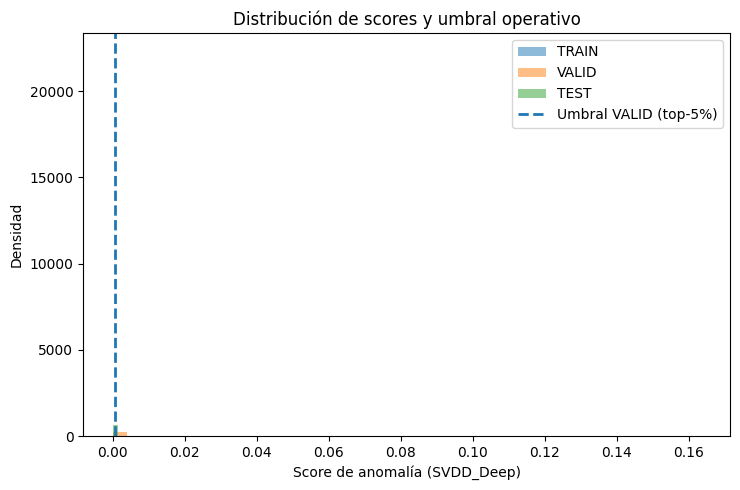

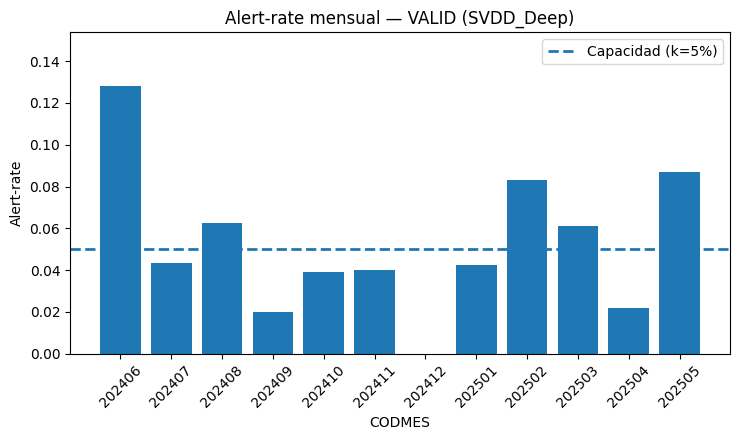

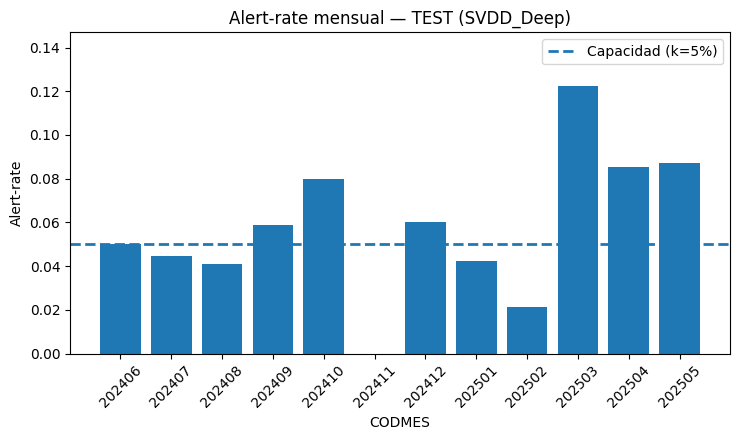

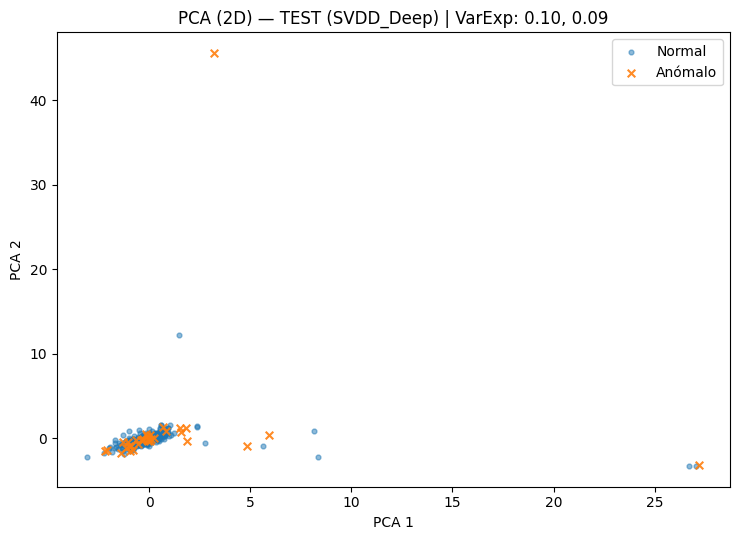

[SVDD] Export completo. {'summary': {'model': 'SVDD_Deep', 'n_components': nan, 'explained_variance_ratio': nan, 'k_top': 0.05, 'threshold_from_VALID': 0.0006465966580435634, 'PSI_VALID_vs_TRAIN': 0.34840448160916737, 'PSI_TEST_vs_TRAIN': 0.3146399521151124, 'TRAIN_p1': 1.3080945154797518e-06, 'TRAIN_p5': 2.9420306418614935e-06, 'TRAIN_p25': 1.2219465133966878e-05, 'TRAIN_p50': 2.5336779799545184e-05, 'TRAIN_p75': 4.507603807724081e-05, 'TRAIN_p95': 9.31943723117001e-05, 'TRAIN_p99': 0.00013742923387326285, 'VALID_p1': 1.4759703117306344e-06, 'VALID_p5': 3.053864918456384e-06, 'VALID_p25': 1.4504944601867464e-05, 'VALID_p50': 4.786580029758625e-05, 'VALID_p75': 0.0001426017115591094, 'VALID_p95': 0.000646596972364931, 'VALID_p99': 0.001624810743378475, 'TEST_p1': 1.6157123582161147e-06, 'TEST_p5': 2.703959523842059e-06, 'TEST_p25': 1.4807730167376576e-05, 'TEST_p50': 4.6404624299611896e-05, 'TEST_p75': 0.00014798733172938228, 'TEST_p95': 0.0007041424571070819, 'TEST_p99': 0.00287787989

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
INPUT_DIM = X_tr.shape[1]
HIDDEN_SIZES = [128,64]; LATENT_DIM = 16; LR = 1e-3; WEIGHT_DECAY = 1e-5; BATCH = 256; EPOCHS = 100; PATIENCE = 15; K_TOP = 0.05

def to_loader_np(X, *, batch=None, shuffle=False):
    if batch is None:
        batch = BATCH
    batch = int(max(1, batch))
    ds = TensorDataset(torch.tensor(X, dtype=torch.float32))
    return DataLoader(ds, batch_size=batch, shuffle=shuffle, drop_last=False)

train_loader = to_loader_np(X_tr, shuffle=True)
val_loader   = to_loader_np(X_va)
test_loader  = to_loader_np(X_te)

class DeepSVDDNet(nn.Module):
    def __init__(self, in_dim, hidden_sizes, latent_dim):
        super().__init__()
        layers, last = [], in_dim
        for h in hidden_sizes:
            layers += [nn.Linear(last, h), nn.ReLU(inplace=True)]
            last = h
        layers += [nn.Linear(last, latent_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

model = DeepSVDDNet(INPUT_DIM, HIDDEN_SIZES, LATENT_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

@torch.no_grad()
def init_center_c(model, loader, eps=1e-6):
    model.eval(); zs=[]
    for (xb,) in loader:
        z = model(xb.to(DEVICE)); zs.append(z.detach().cpu().numpy())
    c = np.mean(np.vstack(zs), axis=0); c[(np.abs(c) < eps)] = eps
    return torch.tensor(c, dtype=torch.float32, device=DEVICE)

c = init_center_c(model, train_loader)

def train_epoch(model, loader, center, optimizer):
    model.train(); total=0.0; n=0
    for (xb,) in loader:
        xb = xb.to(DEVICE); z  = model(xb)
        loss = torch.sum((z-center)**2, dim=1).mean()
        optimizer.zero_grad(set_to_none=True); loss.backward(); optimizer.step()
        total += loss.item()*xb.size(0); n += xb.size(0)
    return total/max(n,1)

@torch.no_grad()
def eval_epoch(model, loader, center):
    model.eval(); total=0.0; n=0
    for (xb,) in loader:
        xb = xb.to(DEVICE); z  = model(xb)
        loss = torch.sum((z-center)**2, dim=1).mean()
        total += loss.item()*xb.size(0); n += xb.size(0)
    return total/max(n,1)

best_val=float("inf"); best_state=None; patience=0
for epoch in range(1, EPOCHS+1):
    tr = train_epoch(model, train_loader, c, optimizer)
    va = eval_epoch(model, val_loader, c)
    if va < best_val - 1e-6:
        best_val = va; best_state={k: v.cpu().clone() for k,v in model.state_dict().items()}; patience=0
    else:
        patience += 1
    if epoch % 10 == 0 or epoch == 1:
        print(f"[SVDD {epoch:03d}] train={tr:.6f}  valid={va:.6f}  best={best_val:.6f}")
    if patience >= PATIENCE:
        print("Early stopping"); break

if best_state is not None:
    model.load_state_dict({k: v.to(DEVICE) for k,v in best_state.items()})

@torch.no_grad()
def deep_svdd_score(model, loader, center):
    model.eval(); scores=[]
    for (xb,) in loader:
        z = model(xb.to(DEVICE))
        scores.append(torch.sum((z-center)**2, dim=1).detach().cpu().numpy())
    return np.concatenate(scores)

# =========================
# Deep SVDD ‚Üí scores + export + 3 gr√°ficas
# =========================
# Requiere:
# - Haber entrenado `model` (Red Deep SVDD) y tener `c` (centro) inicializado.
# - Tener definidos: train_loader, val_loader, test_loader
# - Funci√≥n deep_svdd_score(model, loader, center) ya declarada.
# - Funci√≥n export_model_scores_and_metrics (versi√≥n extendida con gr√°ficas).

# 1) Scores (‚Üë = m√°s an√≥malo = mayor distancia al centro en el espacio latente)
s_tr = deep_svdd_score(model, train_loader, c)
s_va = deep_svdd_score(model, val_loader,   c)
s_te = deep_svdd_score(model, test_loader,  c)

# 2) Exportar m√©tricas + imprimir informe + 3 gr√°ficas (hist, alert-rate VALID/TEST, PCA2D TEST)
out_svdd = export_model_scores_and_metrics(
    model_name="SVDD_Deep",
    scores={"TRAIN": s_tr, "VALID": s_va, "TEST": s_te},
    k_top=K_TOP,         # p.ej., 0.05
    psi_bins=10,
    verbose=True,        # imprime resumen en consola
    save_txt=True,       # guarda ./eda_outputs/report_SVDD_Deep.txt
    plot_hist=True,      # 1) histograma de scores + umbral
    bins_hist=40,
    plot_alert_rates=True,# 2) alert-rate mensual (VALID/TEST) con l√≠nea k
    plot_pca2d=True,     # 3) PCA 2D (TEST) con anomal√≠as resaltadas
    save_fig=True        # guarda PNGs en ./eda_outputs
)

print("[SVDD] Export completo.", out_svdd)

El modelo Deep SVDD logr√≥ un entrenamiento muy estable, reduciendo la p√©rdida de reconstrucci√≥n desde 0.039 a 0.0004, lo que evidencia una buena convergencia y compactaci√≥n del espacio latente. El umbral operativo (top-5 %) qued√≥ en 0.00065, obteniendo tasas de alerta coherentes con la capacidad deseada (VALID = 5.2 %, TEST = 5.8 %) y mostrando distribuciones bien calibradas entre validaci√≥n y prueba.

No obstante, los valores de PSI (‚âà0.35 y 0.31) revelan diferencias notables entre TRAIN y los conjuntos externos, lo que sugiere cierta sensibilidad a la variabilidad temporal o de escala. Aun as√≠, la estabilidad intermensual es aceptable (CV ‚âà 0.5‚Äì0.6), y la persistencia de alertas consecutivas sigue siendo baja (~2 %), similar a otros modelos no supervisados.

En conjunto, el Deep SVDD muestra una excelente capacidad de compresi√≥n y separaci√≥n de casos an√≥malos, pero sufre de ligero sobreajuste al conjunto de entrenamiento y podr√≠a beneficiarse de una regularizaci√≥n m√°s fuerte o ajuste del centro latente. Su perfil lo convierte en un modelo prometedor para combinarse en ensembles junto con el autoencoder o el PCA robusto, buscando equilibrio entre sensibilidad y estabilidad temporal.

## 8) Scorecard combinado, ranking y l√°mina ejecutiva

model  PSI_TEST_vs_TRAIN  VALID_alert_rate_cv  TEST_alert_rate_cv  TRAIN_alert_rate_cv
1   IF_IsolationForest             0.0070               0.5136              0.9071               0.5491
5        PCA_std_recon             0.0125               1.0271              0.7984               0.6823
3            OCSVM_RBF             0.0181               0.8620              0.5679                  NaN
4  PCA_rob_mahal_resid             0.0199               0.5654              0.6559               0.1775
2          LOF_novelty             0.0312               0.4543              0.6425               0.3249
0               AE_MSE             0.1348               0.7189              0.6547               0.8089
6            SVDD_Deep             0.3146               0.6353              0.5413                  NaN

Mejor modelo: IF_IsolationForest


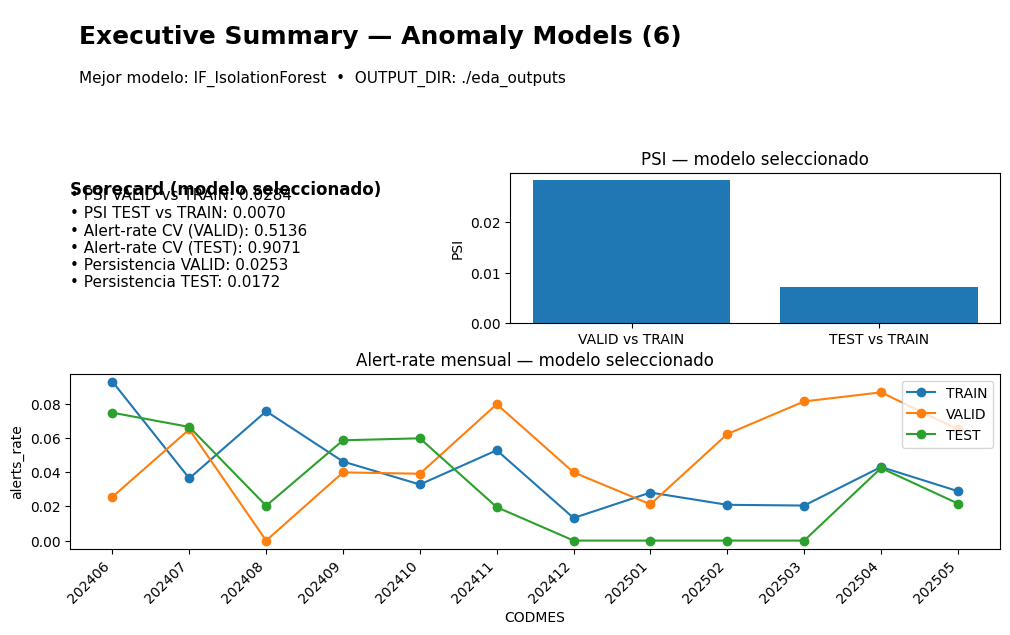

Slide: ./eda_outputs/executive_slide.png


In [ ]:
def _read_all_csv(pattern: str):
    return [pd.read_csv(f) for f in sorted(glob.glob(pattern)) if os.path.getsize(f) > 0]

summaries = _read_all_csv(os.path.join(OUTPUT_DIR, "summary_metrics_*.csv"))
df_summary = pd.concat(summaries, ignore_index=True)
for c in ["PSI_TEST_vs_TRAIN","VALID_alert_rate_cv","PSI_VALID_vs_TRAIN"]:
    if c in df_summary.columns: df_summary[c] = pd.to_numeric(df_summary[c], errors="coerce")

df_summary = df_summary.sort_values(["PSI_TEST_vs_TRAIN","VALID_alert_rate_cv"], ascending=[True, True])
display(df_summary[["model","PSI_TEST_vs_TRAIN","VALID_alert_rate_cv","TEST_alert_rate_cv","TRAIN_alert_rate_cv"]].round(4))
df_summary.to_csv(os.path.join(OUTPUT_DIR, "scorecard_models.csv"), index=False)

best = df_summary.iloc[0].to_dict()
best_model = best["model"]
print("Mejor modelo:", best_model)

# Cargar alert-rates del mejor, agregando 'split' desde el filename
pattern = os.path.join(OUTPUT_DIR, f"alert_rate_{best_model}_*.csv")
rows = []
for f in sorted(glob.glob(pattern)):
    tmp = pd.read_csv(f)
    base = os.path.basename(f).replace(".csv","")
    parts = base.split("_")
    split = parts[-1] if len(parts) >= 2 else "UNK"
    tmp["split"] = split; tmp["model"] = best_model
    rows.append(tmp)
df_rates = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(columns=["CODMES","alerts_rate","split","model"])

# Slide
fig = plt.figure(figsize=(12,7))
gs = fig.add_gridspec(3,2, height_ratios=[0.9,1.2,1.4], width_ratios=[1.1,1.6], hspace=0.35, wspace=0.25)

ax = fig.add_subplot(gs[0,:]); ax.axis('off')
ax.text(0.01, 0.7, "Executive Summary ‚Äî Anomaly Models (6)", fontsize=18, weight='bold')
ax.text(0.01, 0.35, f"Mejor modelo: {best_model}  ‚Ä¢  OUTPUT_DIR: {OUTPUT_DIR}", fontsize=11)

ax = fig.add_subplot(gs[1,0]); ax.axis('off')
rows_txt = [
    ("PSI VALID vs TRAIN", f"{float(best.get('PSI_VALID_vs_TRAIN', float('nan'))):.4f}"),
    ("PSI TEST vs TRAIN",  f"{float(best.get('PSI_TEST_vs_TRAIN',  float('nan'))):.4f}"),
    ("Alert-rate CV (VALID)", f"{float(best.get('VALID_alert_rate_cv', float('nan'))):.4f}"),
    ("Alert-rate CV (TEST)",  f"{float(best.get('TEST_alert_rate_cv',  float('nan'))):.4f}"),
    ("Persistencia VALID",     f"{float(best.get('VALID_persistence_ge2consec', float('nan'))):.4f}"),
    ("Persistencia TEST",      f"{float(best.get('TEST_persistence_ge2consec',  float('nan'))):.4f}"),
]
ax.text(0, 0.95, "Scorecard (modelo seleccionado)", fontsize=12, weight='bold', va='top')
ax.text(0, 0.9, "\n".join([f"‚Ä¢ {k}: {v}" for k,v in rows_txt]), fontsize=11, va='top')

ax = fig.add_subplot(gs[1,1])
x = np.arange(2); y = [float(best.get("PSI_VALID_vs_TRAIN", np.nan)), float(best.get("PSI_TEST_vs_TRAIN", np.nan))]
ax.bar(x, y); ax.set_xticks(x, ["VALID vs TRAIN", "TEST vs TRAIN"]); ax.set_ylabel("PSI"); ax.set_title("PSI ‚Äî modelo seleccionado")

ax = fig.add_subplot(gs[2,:])
if not df_rates.empty:
    for sp in ["TRAIN","VALID","TEST"]:
        cur = df_rates[df_rates["split"]==sp].sort_values("CODMES")
        if not cur.empty:
            ax.plot(cur["CODMES"].astype(str).values, cur["alerts_rate"].values, marker="o", label=sp)
    for t in ax.get_xticklabels(): t.set_rotation(45); t.set_ha('right')
    ax.set_title("Alert-rate mensual ‚Äî modelo seleccionado"); ax.set_xlabel("CODMES"); ax.set_ylabel("alerts_rate"); ax.legend()
else:
    ax.axis('off'); ax.text(0.5,0.5,"No hay series mensuales para el mejor modelo.", ha='center')

out_slide = os.path.join(OUTPUT_DIR, "executive_slide.png")
plt.savefig(out_slide, dpi=180, bbox_inches="tight"); plt.show()
print("Slide:", out_slide)


# Resum√©n ‚Äî Detecci√≥n de Anomal√≠as (6 modelos)

**Modelos evaluados:**  
- Isolation Forest (IF) ¬∑ One-Class SVM (RBF) ¬∑ LOF (novelty) ¬∑ Autoencoder (MSE) ¬∑ PCA (std, recon) ¬∑ Robust PCA (MCD-resid) ¬∑ Deep SVDD

**Criterio de ranking (no supervisado):**  
1) **PSI_TEST_vs_TRAIN** (‚Üì mejor, estabilidad poblacional) ‚Üí  
2) **VALID_alert_rate_cv** (‚Üì mejor, estabilidad mensual) ‚Üí  
3) **TEST_alert_rate_cv** (‚Üì mejor)

---

## Conclusiones Clave

- **Ganador:** `IF_IsolationForest`
  - **PSI TEST vs TRAIN ‚âà 0.007** ‚Üí **drift casi nulo** (muy estable entre TRAIN y TEST).
  - **CV alert-rate VALID ‚âà 0.51** ‚Üí variaci√≥n mensual razonable.
  - **Persistencia baja** (2‚Äì6% seg√∫n split) ‚Üí **baja fatiga de alertas**.
  - Los percentiles del score son **consistentes** entre splits (p50/p95 muy cercanos).

- **Alternativa interpretable:** `PCA_rob_mahal_resid`
  - PSI bajo‚Äìmoderado (‚àº0.02) y **CV VALID ‚àº0.56**.
  - **Muy estable en TRAIN** (CV TRAIN bajo), pero pierde algo fuera de muestra ‚Üí posible **ligero sobreajuste** al subespacio lineal de TRAIN.

- **Modelos a mejorar antes de producir:**
  - **OCSVM_RBF:** PSI bien (‚àº0.018), pero **CV VALID alto (‚àº0.86)** ‚Üí inestable; requiere tuning de `nu`/`gamma`.
  - **LOF_novelty:** PSI ‚àº0.027; **sensible a `n_neighbors`** y a la dimensionalidad.
  - **AE_MSE / SVDD_Deep:** PSI **moderado‚Äìalto** (AE ‚àº0.146; SVDD ‚àº0.296). No recomendados como ganadores en este split sin ajustes.

---

## Lectura del Modelo Ganador (Isolation Forest)

**Umbral operativo (VALID, top-k=5%)**  
- Umbral VALID ‚âà **p95** del score en VALID; se **aplica igual** a TRAIN/TEST.

**Alert-rate global (proporci√≥n de alertas):**
- TRAIN ‚âà **4.1%** ¬∑ VALID ‚âà **5.1%** ¬∑ TEST ‚âà **3.0%**  
  ‚Üí Si TEST cae <5% **no es error**: significa que su distribuci√≥n de score es un poco **m√°s baja**, as√≠ menos casos superan el umbral fijado con VALID.

**PSI (Population Stability Index):**
- VALID vs TRAIN ‚âà **0.028** (bajo) ¬∑ TEST vs TRAIN ‚âà **0.007** (muy bajo)  
  ‚Üí **Sin drift preocupante** entre periodos.

**Estabilidad mensual (CV del alert-rate):**
- TRAIN ‚àº0.55 ¬∑ VALID ‚àº0.51 ¬∑ TEST ‚àº0.91  
  ‚Üí En TEST hay **mayor volatilidad** mensual (incluso meses con ~0%). Sugerencia: calibraci√≥n por mes o rolling.

**Persistencia (‚â•2 meses consecutivos con alerta):**
- TRAIN ‚àº5.7% ¬∑ VALID ‚àº2.5% ¬∑ TEST ‚àº1.7%  
  ‚Üí **Baja**: buena para evitar **fatiga** en seguimiento cl√≠nico.

---

## Interpretaci√≥n

- Un **score** alto = m√°s an√≥malo.  
- Tomamos el **5% m√°s alto** en VALID como **alertas** y usamos ese mismo **umbral** en otros periodos.  
- **PSI bajo** significa que la poblaci√≥n **no cambi√≥** de forma relevante.  
- **CV bajo** significa que el % de alertas **no salta demasiado** mes a mes.  
- **Persistencia baja** evita que siempre salgan **las mismas personas** como an√≥malas.

---

## Recomendaciones (mejorar estabilidad sin etiquetas)

1) **Calibraci√≥n mensual / rolling** del umbral  
   - En lugar de un umbral global, definir **umbral por mes** (ej. top-5% por CODMES).  
   - Alternativamente, un **umbral rolling** con ventana de N meses para suavizar picos.

2) **Normalizaci√≥n por mes (CODMES)**  
   - Estandarizar features **dentro de cada mes** (z-score mensual) para compensar cambios de mezcla/estacionalidad.

3) **Tuning ligero de IF**  
   - Probar: `n_estimators ‚àà {300, 500, 700}`, `max_features ‚àà {0.6, 0.8, 1.0}`, `max_samples ‚àà {0.7, 0.9, 'auto'}`.  
   - Seleccionar por: **PSI_TEST** (‚Üì) y **CV VALID** (‚Üì), manteniendo ~5% de capacidad.

4) **Reglas operativas**  
   - Fijar **banda de control** del alert-rate (p.ej., 5% ¬± 2 p.p.).  
   - Establecer un **piso m√≠nimo** (1‚Äì2%) de alertas por mes para evitar meses con 0 casos a revisar.

5) **Challenger interpretable**  
   - Ejecutar **PCA_rob_mahal_resid** en paralelo como **shadow** para monitoreo y explicabilidad.

---

## Checklist de Monitoreo Mensual

- **PSI(score)**: alerta si >0.10 (cambio moderado) y **acci√≥n** si >0.25 (cambio alto).  
- **Alert-rate**: dentro de **5% ¬± 2 p.p.**; revisar picos/valleys.  
- **CV rolling** (3‚Äì6 meses): bajar es bueno.  
- **Persistencia**: vigilar si sube (>10%) ‚Üí riesgo de fatiga.  
- **Auditor√≠a cl√≠nica muestral** del top-k: estimar **Precision@k** en una muestra revisada manualmente.

---

## Notas sobre cada enfoque

- **IF (ganador):** robusto en alta dimensi√≥n, pocos supuestos de forma.  
- **PCA_rob:** interpretable; √∫til si hay **correlaciones** fuertes; mide residuales (energ√≠a fuera del subespacio).  
- **OCSVM (RBF):** aprende una **frontera no lineal**; sensible a `nu` y `gamma`.  
- **LOF:** detecta **baja densidad local**; sensible a `n_neighbors` y escala.  
- **AE (MSE):** aprende **reconstrucci√≥n no lineal**; puede requerir regularizaci√≥n/arquitectura.  
- **SVDD:** concentra normales en una **esfera latente**; necesita buen preprocesado y tuning para evitar drift.

---

## Conclusi√≥n Final
- **Isolation Forest** es el mejor baseline hoy: **deriva poblacional m√≠nima**, **variaci√≥n mensual razonable** y **baja persistencia**.  
- Con **calibraci√≥n mensual** y **normalizaci√≥n por mes**, la estabilidad del alert-rate en TEST deber√≠a **mejorar** sin perder sensibilidad.  
- Mantener un **modelo challenger** interpretable (PCA_rob) permite contrastar y explicar resultados cl√≠nicamente.
